In [1]:
from pyalex import Works, Authors, Sources, Institutions, Topics, Publishers, Funders, Concepts
import pandas as pd
import numpy as np
import urllib.parse
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# !pip install pyalex # uncomment to install

In [3]:
# ANSI escape codes for colors
GREEN = '\033[92m'
RED = '\033[91m'
YELLOW = '\033[93m'
BLUE = '\033[94m'
RESET = '\033[0m'
MAGENTA = '\033[35m'
CYAN = '\033[36m'

## Reading (and sampling) the data

`biomedical_data.csv` is a subset of the original dataset containing publications __from the last 5 years__ and from __biomedical institutions only__ - amcpub, lumc, vumc, umcu. It contains 1856 records.

In [4]:
df = pd.read_csv("biomedical_data.csv")
sampled_df = df.sample(n=200, random_state=42)

In [5]:
def author_title_pairs_lst(df):
    tuples_list = []                                             # create pairs (author, title) for each row of the df
    for index, row in df.iterrows():
        tuple_values = (row['author_name'], row['title'])
        tuples_list.append(tuple_values)
    return tuples_list

def contributors_lst(df):
    contributors_list = []                                       # create lists of contributors for each row of the df
    for index, row in df.iloc[:, 7:18].iterrows():
        contributors = []
        for value in row:
            if type(value) != float:
                contributors.append(value)
        contributors_list.append(contributors)
    return contributors_list

In [6]:
author_title_pairs = author_title_pairs_lst(sampled_df)
contributors_list = contributors_lst(sampled_df)

## Find the author

#### Get pubs from our df

In [7]:
def get_name(row):                                                     # needs a row of the pubs df
    author = author_title_pairs[row][0]
    if "," not in author:
        surname = author.split(" ")[0]
        initials = author.split(" ")[1].strip()
    else:
        surname = author.split(",")[0]
        initials = author.split(",")[1].strip()
    matched_initials = re.findall(r'\b[A-Z](?:\.[A-Z])\b', initials)   # adding space between initials if there is no
    if len(matched_initials)>0 and len(matched_initials[0])>2:         # essential transformation if authors cannot be matched
        initials_list = list(initials)                                 # with found title
        for initial in initials_list:
            if initial == ".":
                initials_list.remove(initial)
        name = ""
        for initial in initials_list:
            name += initial + ". "
        name += surname
    else:
        name = initials + " " + surname
    return name

def get_name_without_spaces(row):                                      # name as it is in the pubs df
    author = author_title_pairs[row][0]
    if "," not in author:
        surname = author.split(" ")[0]
        initials = author.split(" ")[1].strip()
    else:
        surname = author.split(",")[0]
        initials = author.split(",")[1].strip()
    name = initials + " " + surname
    return name

In [8]:
def title_transform(row):
    title = author_title_pairs[row][1]
    replace_dict = {'&': '', ',': ''}
    for k,v in replace_dict.items():
        title = title.replace(k,v)
    title = urllib.parse.quote(title)
    return title

#### Confirm the author

In [9]:
def confirm_author(row):                                                 # match to existing work, if not found, search by name

    author_id = ''

    try:
        query = Works().search_filter(title=title_transform(row)).get()

        if query == []:
            return "Title not matched"    # based on name

        print(f'{len(query)} match(es) for the title found')
        for response in query:
            found = False
            if response["authorships"] == []:
                print("No record of author for this title")
            for author in response["authorships"]:
                if author["author"]["display_name"] == get_name(row):    # first try matching on "raw" name
                    print(MAGENTA + "Author found! - {}".format(get_name(row)) + RESET)
                    author_id = author["author"]["id"]
                    found = True
                if found == False:                                       # raw name matches based on the exact same string
                    q = Authors()[author["author"]["id"]]                # if not found check with ID
                    if (q["display_name"] == get_name(row) or get_name(row) in q["display_name_alternatives"]) or (q["display_name"] == get_name_without_spaces(row) or get_name_without_spaces(row) in q["display_name_alternatives"]):
                        print(YELLOW + "Author found! - {}".format(get_name(row)) + RESET)
                        author_id = author["author"]["id"]
                        found = True
                    if (q["display_name"].lower() == get_name(row).lower() or q["display_name"].lower() == get_name_without_spaces(row).lower()):
                        print(YELLOW + "Author found! - {}".format(get_name(row)) + RESET)
                        author_id = author["author"]["id"]
                        found = True
                    if q["display_name_alternatives"] != []:
                        for n in q["display_name_alternatives"]:
                            if (n.lower() == get_name(row).lower() or n.lower() == get_name_without_spaces(row).lower()):
                                print(YELLOW + "Author found! - {}".format(get_name(row)) + RESET)
                                author_id = author["author"]["id"]
                                found = True
                    if found == False:
                        print("Could not match {} to {}".format(get_name(row), q["display_name_alternatives"]))
                if found:
                    break
            if found:
                break


    except Exception as e:
        print("An unexpected error occurred:", e)


    if author_id != '':
        return author_id
    if author_id == None:
        return "Confirming author not successful"
    else:
        return "Confirming author not successful"

In [10]:
def title_DOI(row, confirmed_id):                                         # returns DOI of the title if the author is matched
                                                                          # based on that title
    DOIs = []

    if confirmed_id not in ["Confirming author not successful", "Title not matched"]:
        query = Works().search_filter(title=title_transform(row)).get()
        for response in query:
            DOIs.append(response["doi"])

    return DOIs

In [11]:
def get_author_id(row):                                                   # returns final author ID

    confirmed_id = confirm_author(row)

    if confirmed_id not in ["Confirming author not successful", "Title not matched"]:
        return confirmed_id

    query = Authors().search_filter(display_name=get_name(row)).get()

    if query == []:
        query = Authors().search_filter(display_name=get_name_without_spaces(row)).get()

    end_message = confirmed_id
    confirmed_id = ''

    print("{} match(es) for the author found".format(len(query)))
    for response in query:
        found = False
        if (response["display_name"] == get_name(row) or get_name(row) in response["display_name_alternatives"]) or (response["display_name"] == get_name_without_spaces(row) or get_name_without_spaces(row) in response["display_name_alternatives"]):
            print(BLUE + "Author found! - {}".format(get_name(row)) + RESET)
            confirmed_id = response["id"]
            found = True
        else:                                                               # many other cases ! - DOUBLE SURNAMES - NOT CLEAR WAY TO HANDLE (193 on rs 42)
            if get_name(row).lower() == response["display_name"].lower():
                print(CYAN + "Author found! - {}".format(get_name(row)) + RESET)
                confirmed_id = response["id"]
                found = True
            normalized_name1 = ' '.join(sorted(get_name(row).split()))
            normalized_name2 = ' '.join(sorted(response["display_name"].split()))
            if normalized_name1 == normalized_name2:
                print(CYAN + "Author found! - {}".format(get_name(row)) + RESET)
                confirmed_id = response["id"]
                found = True
        if found:
            break

    if confirmed_id != '':
        return confirmed_id
    else:
        return "Author (probably) not in Open Alex database"                 # OR AUTHOR NOT MATCHED !

Output colors:

__Magenta__ - author found in OpenAlex authors based on matched title

__Yellow__ - author found in OpenAlex authors based on matched title, for alternative version of author's name

__Blue__ - author found in OpenAlex authors

__Cyan__ - alternative version of author's name (likely the author) found in OpenAlex authors

## Get DOIs for the author

Not every work in Open Alex has a DOI, thus the returned list of DOIs may be shorter than the number of papers where the author was the first author. The DOI of the work that is already in pubs dataframe is also not included in the list - __only new DOIs are returned__.

In [12]:
def author_DOIs(row):

    author_id = get_author_id(row)
    if author_id == "Author (probably) not in Open Alex database":
        print(RED + "Cannot be resolved" + RESET)
        return author_id
    initial_doi = title_DOI(row, author_id)

    result = Works().filter(authorships={"author": {"id": author_id}}).get()
    print("Number of papers where the author was credited: {}".format(len(result)))

    DOIs = []

    i = 0
    for w in result:
        if w["authorships"][0]["author"]["id"] == author_id:
            i += 1
            if w["doi"] != None and w["doi"] not in initial_doi:
                DOIs.append(w["doi"])

    print("Number of papers where the author was the first author: {}".format(i))

    if DOIs == []:
        return "No DOIs for the author found"
    else:
        return DOIs

In [13]:
# author_DOIs(1)

## Get DOIs for the contributors

#### Transform contributors' names

In [14]:
def contributors_transformed(row):                                             # with space

    contributors = contributors_list[row]
    transformed_names = []

    for contribtor in contributors:
        surname = contribtor.split(",")[0]
        initials = contribtor.split(",")[1].strip()
        matched_initials = re.findall(r'\b[A-Z](?:\.[A-Z])\b', initials)
        if len(matched_initials)>0 and len(matched_initials[0])>2:
            initials_list = list(initials)
            for initial in initials_list:
                if initial == ".":
                    initials_list.remove(initial)
            name = ""
            for initial in initials_list:
                name += initial + ". "
            name += surname
        else:
            name = initials + " " + surname
        transformed_names.append(name)

    return transformed_names

def contributors_original(row):                                                # as originally in the data
                                                                               # will be used when the transformed names won't
    contributors = contributors_list[row]                                      # match
    transformed_names = []

    for contribtor in contributors:
        surname = contribtor.split(",")[0]
        initials = contribtor.split(",")[1].strip()
        name = initials + " " + surname
        transformed_names.append(name)

    return transformed_names

#### Find contributors (get IDs)

In [15]:
def get_contributors_ids(row):                                                 # returns a list of tuples of contributors and
                                                                               # their corresponding confirmed ids
    contributors = contributors_transformed(row)
    original_contributors = contributors_original(row)
    contributors_ids = []

    for contributor, og_contributor in zip(contributors, original_contributors):
        print("Matching {}...".format(contributor))
        found = False
        response_list = []
        query = Authors().search_filter(display_name=contributor).get()        # 2 queries everytime could be too comp expens.
        if query == []:                                                        # check the difference?
            query = Authors().search_filter(display_name=og_contributor).get()
        if query == []:
            print(RED + "        Cannot be resolved: " + RESET + "Could not find the author {}".format(contributor))
        else:
            print("        Found {} matches for {}".format(len(query), contributor))
            for i, response in enumerate(query):
                print("          {}:".format(i+1))
                if (response["display_name"] == contributor or contributor in response["display_name_alternatives"]) or (response["display_name"] == og_contributor or og_contributor in response["display_name_alternatives"]):
                    print(BLUE + "            Contributor found! - {}".format(contributor) + RESET)
                    contributors_ids.append((contributor, response["id"]))
                    found = True
                else:
                    if contributor.lower() == response["display_name"].lower():
                        print(CYAN + "            Contributor found! - {}".format(contributor) + RESET)
                        contributors_ids.append((contributor, response["id"]))
                        found = True
                if found == False:
                    if response["affiliations"] == []:
                        print(RED + "            No affiliations with institutions - unable to match" + RESET)
                    else:
                        for institution in response["affiliations"]:
                            if institution["institution"]["country_code"] == "NL":
                                print("            {} associated with {}, NL".format(response["display_name"], institution["institution"]["display_name"]))
                                print("            {} maybe associated with {}".format(contributor, response["display_name"]))
                                print(MAGENTA + "            Requires manual check to confirm" + RESET)
                                if ("MANUAL CHECK: if {} (target) is {} (found)".format(contributor, response["display_name"]), response["id"]) not in contributors_ids:
                                    response_list.append(("MANUAL CHECK: if {} (target) is {} (found)".format(contributor, response["display_name"]), response["id"]))
                            else:
                                print(RED + "            No NL institution - unlikely to be the match" + RESET)
                if found:
                    break
                if i == len(query)-1:
                    contributors_ids.extend(response_list)

    if contributors_ids == []:
        return "None of the contributors is in Open Alex database"
    else:
        return contributors_ids

### Get DOIs

In [16]:
def contributors_DOIs(row):

    ids_list = get_contributors_ids(row)
    confirmed = []
    manual_check = []

    for pair in ids_list:
        if "MANUAL CHECK" in pair[0]:
            if pair not in manual_check:
                manual_check.append(pair)
        else:
            confirmed.append(pair)

    if ids_list == "None of the contributors is in Open Alex database":
        return ids_list


    DOIs_dict = {}

    for author in confirmed:
        author_id = author[1]
        result = Works().filter(authorships={"author": {"id": author_id}}).get()
        print()
        print("Searching works for {}...".format(author[0]))
        print("        Number of papers where the contributor was credited as an author: {}".format(len(result)))

        DOIs = []

        i = 0
        for w in result:
            if w["authorships"][0]["author"]["id"] == author_id:
                i += 1
                if w["doi"] != None:
                    DOIs.append(w["doi"])

        print("        Number of papers where the contributor was the first author: {}".format(i))

        if author[0] not in DOIs_dict:
            DOIs_dict[author[0]] = DOIs

    for author in manual_check:
        author_id = author[1]
        extract_name = re.search(r'if\s+(.*?)\s+is', author[0])
        name = extract_name.group(1)
        result = Works().filter(authorships={"author": {"id": author_id}}).get()
        print()
        print("Searching works for {}... - NOT CONFIRMED".format(name))
        print("        Number of papers where the contributor was credited as an author: {}".format(len(result)))

        DOIs = []

        i = 0
        for w in result:
            if w["authorships"][0]["author"]["id"] == author_id:
                i += 1
                if w["doi"] != None:
                    DOIs.append(w["doi"])

        print("        Number of papers where the contributor was the first author: {}".format(i))

        name = name + " - NOT CONFIRMED"
        if name not in DOIs_dict:
            DOIs_dict[name] = DOIs


    if DOIs_dict == {}:
        return "No DOIs for the associated contributors found"

    got_dois = False
    for value in DOIs_dict.values():
        if value != []:
            got_dois = True
    if got_dois:
        return DOIs_dict
    else:
        return "No DOIs for the associated contributors found"

In [17]:
# contributors_DOIs(3)

## Run on a subset

Store the output in `dois_df`

In [18]:
# dois_df = pd.DataFrame(columns=['Author', 'Author DOIs found in OpenAlex', 'DOIs count', 'Contributors-DOIs Dictionary', 'Number of contributors with DOIs found in OpenAlex', 'Cumulative found Contributor DOIs count'])

# for i in tqdm(range(len(sampled_df))):
#     contributors = contributors_DOIs(i)
#     if contributors == "None of the contributors is in Open Alex database" or contributors == "No DOIs for the associated contributors found":
#         contributors = np.nan
#         contr_count = 0
#         contr_dois_count = 0
#     else:
#         contr_count = 0
#         for lst in contributors.values():
#             if lst != []:
#                 contr_count += 1
#         contr_dois_count = 0
#         for lst in contributors.values():
#             contr_dois_count += len(lst)
#     author_dois = author_DOIs(i)
#     if author_dois == "Author (probably) not in Open Alex database" or author_dois == "No DOIs for the author found":
#         author_dois = np.nan
#         count = 0
#     else:
#         count = len(author_dois)
#     data = {'Author': get_name_without_spaces(i), 'Author DOIs found in OpenAlex': author_dois, 'DOIs count': count, 'Contributors-DOIs Dictionary': contributors, 'Number of contributors with DOIs found in OpenAlex': contr_count, 'Cumulative found Contributor DOIs count': contr_dois_count}
#     dois_df = dois_df.append(data, ignore_index=True)

In [19]:
dois_data = []

for i in tqdm(range(len(sampled_df))):
    contributors = contributors_DOIs(i)
    if contributors == "None of the contributors is in Open Alex database" or contributors == "No DOIs for the associated contributors found":
        message_contributors = contributors
        contributors = np.nan
        contr_count = 0
        contr_dois_count = 0
    else:
        contr_count = sum(1 for lst in contributors.values() if lst)
        contr_dois_count = sum(len(lst) for lst in contributors.values())
        message_contributors = np.nan

    author_dois = author_DOIs(i)
    if author_dois == "Author (probably) not in Open Alex database" or author_dois == "No DOIs for the author found":
        message_author = author_dois
        author_dois = np.nan
        count = 0
    else:
        count = len(author_dois)
        message_author = np.nan

    data = {'Author': get_name_without_spaces(i), 'Author DOIs found in OpenAlex': author_dois, 'DOIs count': count, 'Contributors-DOIs Dictionary': contributors, 'Number of contributors with DOIs found in OpenAlex': contr_count, 'Cumulative found Contributor DOIs count': contr_dois_count, 'Why no DOIs for author': message_author, 'Why no DOIs for contributors': message_contributors}
    dois_data.append(data)

dois_df = pd.DataFrame(dois_data)

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Matching M. I. van Berge Henegouwen...
        Cannot be resolved: Could not find the author M. I. van Berge Henegouwen
Matching P. J. Tanis...
        Found 2 matches for P. J. Tanis
          1:
            P J Tanis associated with Amsterdam University Medical Centers, NL
            P. J. Tanis maybe associated with P J Tanis
            Requires manual check to confirm
            P J Tanis associated with University of Amsterdam, NL
            P. J. Tanis maybe associated with P J Tanis
            Requires manual check to confirm
            P J Tanis associated with Erasmus MC, NL
            P. J. Tanis maybe associated with P J Tanis
            Requires manual check to confirm
          2:
            Contributor found! - P. J. Tanis
Matching R. Hompes...
        Cannot be resolved: Could not find the author R. Hompes
Matching D. M. de Bruin...
        Found 3 matches for D. M. de Bruin
          1:
            de D.M. Bruin associated with Academic Medical Center, NL
     

  0%|▍                                                                                 | 1/200 [00:06<20:11,  6.09s/it]

0 match(es) for the author found
Cannot be resolved
Matching J. M. Prins...
        Found 10 matches for J. M. Prins
          1:
            Pier J. M. Prins associated with Pluryn, NL
            J. M. Prins maybe associated with Pier J. M. Prins
            Requires manual check to confirm
            Pier J. M. Prins associated with University of Amsterdam, NL
            J. M. Prins maybe associated with Pier J. M. Prins
            Requires manual check to confirm
            Pier J. M. Prins associated with Vrije Universiteit Amsterdam, NL
            J. M. Prins maybe associated with Pier J. M. Prins
            Requires manual check to confirm
            Pier J. M. Prins associated with Amsterdam University of the Arts, NL
            J. M. Prins maybe associated with Pier J. M. Prins
            Requires manual check to confirm
            Pier J. M. Prins associated with GGD Amsterdam, NL
            J. M. Prins maybe associated with Pier J. M. Prins
            Requires ma

Could not match Patricia van Velzen to ['Zhipeng Xu', 'Zha Xu', 'Zhengcui Xu', 'Zhixiang Xu', 'Xu Zhenjun', 'Xu Zhi‐Yun', 'Zhenyang Xu', 'Zhonghua Xu', 'Zhong‐Hua Xu', 'Z. Xu', 'Xu Zha', 'Zhi‐xiang Xu', 'Zhiyun Xu', 'Zhen‐Yang Xu', 'XU Zuokui', 'XU Zhi‐xiang', 'Z J Xu', 'XU Zheng‐cui', 'XU Zhen‐yang', 'Xu Zhiyun', 'XU Zufang', 'Zheli Xu', 'XU Zhe‐li', 'Xu Z', 'Zufang Xu', 'Zhi‐Yun Xu', 'Xu Zhonghua', 'Zhe‐Li Xu', 'Zhenjun Xu', 'Zuokui Xu', 'XU Zhi‐peng']
Could not match Patricia van Velzen to ['Cao Bin', 'B. Cao', '曹斌', 'B.I.N.H Cao', 'Borui Cao', 'Bin Cao', 'Bi‐lan Cao', 'Cao B.', 'Binwang Cao', 'Bozhou Cao', 'Binhong Cao', 'Bingwu Cao', 'Botao Cao', 'Cao Bingwu', 'Baoyi Cao', 'Cao Bi‐lan', 'Bingjie Cao']
Could not match Patricia van Velzen to ['Domenico Maurizio Toraldo', 'Domenico M. Toraldo', 'D. M. ToralDo', 'D.M. Toraldo', 'Domenico Toraldo']
Could not match Patricia van Velzen to ['L. Del Conte', 'L. Conte', 'Luana Conte']
Could not match Patricia van Velzen to ['M. Fanning', 'M

  1%|▊                                                                               | 2/200 [01:05<2:03:31, 37.43s/it]

Number of papers where the author was credited: 20
Number of papers where the author was the first author: 7
Matching S. Horenblas...
        Found 14 matches for S. Horenblas
          1:
            Contributor found! - S. Horenblas
Matching A. Bex...
        Found 21 matches for A. Bex
          1:
            Contributor found! - A. Bex

Searching works for S. Horenblas...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0

Searching works for A. Bex...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 2
1 match(es) for the title found
Author found! - Teele Kuusk


  2%|█▏                                                                              | 3/200 [01:09<1:13:19, 22.33s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 4
Matching H.d. Ruijter...
        Found 1 matches for H.d. Ruijter
          1:
            No affiliations with institutions - unable to match
Matching T. Leiner...
        Found 7 matches for T. Leiner
          1:
            No affiliations with institutions - unable to match
          2:
            Contributor found! - T. Leiner

Searching works for T. Leiner...
        Number of papers where the contributor was credited as an author: 2
        Number of papers where the contributor was the first author: 0
1 match(es) for the title found
Author found! - Floor Groepenhoff


  2%|█▋                                                                                | 4/200 [01:13<48:22, 14.81s/it]

Number of papers where the author was credited: 19
Number of papers where the author was the first author: 9
Matching M. A. Grootenhuis...
        Found 3 matches for M. A. Grootenhuis
          1:
            Contributor found! - M. A. Grootenhuis
Matching C. B. Terwee...
        Found 1 matches for C. B. Terwee
          1:
            Contributor found! - C. B. Terwee
Matching L. Haverman...
        Found 3 matches for L. Haverman
          1:
            Contributor found! - L. Haverman
Matching P. Pulmonology...
        Cannot be resolved: Could not find the author P. Pulmonology

Searching works for M. A. Grootenhuis...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 5

Searching works for C. B. Terwee...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0

Searching works for L. Haverman..

  2%|██                                                                                | 5/200 [01:21<40:03, 12.32s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 7
Matching J. Sluijter...
        Found 9 matches for J. Sluijter
          1:
            F. J. H. Sluijter associated with Utrecht University, NL
            J. Sluijter maybe associated with F. J. H. Sluijter
            Requires manual check to confirm
          2:
            E. J. Crul-Sluijter associated with Radboud University Nijmegen, NL
            J. Sluijter maybe associated with E. J. Crul-Sluijter
            Requires manual check to confirm
          3:
            J Jeroen Sluijter associated with Eindhoven University of Technology, NL
            J. Sluijter maybe associated with J Jeroen Sluijter
            Requires manual check to confirm
          4:
            J H Sluijter associated with Leiden University Medical Center, NL
            J. Sluijter maybe associated with J H Sluijter
            Requires manual check to confirm
          5:
            Contr

  3%|██▍                                                                               | 6/200 [01:25<31:23,  9.71s/it]

Number of papers where the author was credited: 6
Number of papers where the author was the first author: 3
Matching B. van Rossum...
        Found 8 matches for B. van Rossum
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            A. B. Van Rossum associated with Rijnstate Hospital, NL
            B. van Rossum maybe associated with A. B. Van Rossum
            Requires manual check to confirm
            A. B. Van Rossum associated with Leide

  4%|██▊                                                                               | 7/200 [01:31<26:57,  8.38s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 13
Matching P. Scheltens...
        Found 18 matches for P. Scheltens
          1:
            Contributor found! - P. Scheltens
Matching C. Stam...
        Found 25 matches for C. Stam
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            Jord C. Stam associated with Leiden University, NL
            C. Stam maybe associated with Jord C. Stam
            Requires manual check to confirm
            Jord C. Stam associated with Netherlands Organisation for Applied Scientific Research, NL
            C. St

  4%|███▎                                                                              | 8/200 [01:37<24:22,  7.62s/it]

0 match(es) for the author found
Cannot be resolved
Matching F. Asselbergs...
        Found 5 matches for F. Asselbergs
          1:
            No NL institution - unlikely to be the match
          2:
            Contributor found! - F. Asselbergs
Matching K. Cheng...
        Found 25 matches for K. Cheng
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlike

  4%|███▋                                                                              | 9/200 [01:42<21:27,  6.74s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 6
Matching D. Klomp...
        Found 7 matches for D. Klomp
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            Sylvia D. Klomp associated with Leiden University Medical Center, NL
            D. Klomp maybe associated with Sylvia D. Klomp
            Requires manual check to confirm
          3:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          4:
            Dennis D W J Klomp associated with University Medical Center Utrecht, NL
            D. Klomp maybe associated with Dennis D W J Klomp
            Requires manual check to confirm
          5:
            No NL institution - unlikely to be the match
          6:
            No affiliations with institutions - unable to match
          7:
            No a

  5%|████                                                                             | 10/200 [01:48<20:35,  6.50s/it]

Number of papers where the author was credited: 8
Number of papers where the author was the first author: 8
Matching E. de Vries...
        Found 25 matches for E. de Vries
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            J E de Vries associated with The Netherlands Cancer Institute, NL
            E. de Vries maybe associated with J E de Vries
            Requires manual check to confirm
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            J E de Vries associated with Oncode Institute, NL
            E. de Vries maybe associated with J E de Vries
            Requires manual check to confirm
            No NL institution - unlikely to be the match
          

        Found 4 matches for J. van Horssen
          1:
            Peter J. van Horssen associated with Nutricia Research (Netherlands), NL
            J. van Horssen maybe associated with Peter J. van Horssen
            Requires manual check to confirm
          2:
            Contributor found! - J. van Horssen
Matching M. Rijnsburger...
        Found 2 matches for M. Rijnsburger
          1:
            Contributor found! - M. Rijnsburger

Searching works for E. de Vries...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 10

Searching works for J. van Horssen...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 1

Searching works for M. Rijnsburger...
        Number of papers where the contributor was credited as an author: 4
        Number of papers where the contributor was the first autho

  6%|████▍                                                                            | 11/200 [01:54<20:03,  6.37s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 3
Matching H. J. Bogaard...
        Found 6 matches for H. J. Bogaard
          1:
            Contributor found! - H. J. Bogaard
Matching L. Meijboom...
        Found 4 matches for L. Meijboom
          1:
            Contributor found! - L. Meijboom
Matching P. Symersky...
        Found 1 matches for P. Symersky
          1:
            Contributor found! - P. Symersky

Searching works for H. J. Bogaard...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0

Searching works for L. Meijboom...
        Number of papers where the contributor was credited as an author: 2
        Number of papers where the contributor was the first author: 0

Searching works for P. Symersky...
        Number of papers where the contributor was credited as an author: 0
        Number of papers where the cont

  6%|████▊                                                                            | 12/200 [01:58<18:13,  5.82s/it]

0 match(es) for the author found
Cannot be resolved
Matching J.d. Ridder...
        Cannot be resolved: Could not find the author J.d. Ridder
1 match(es) for the author found
Author found! - Marleentje Martha Nieboer


  6%|█████▎                                                                           | 13/200 [02:02<16:29,  5.29s/it]

Number of papers where the author was credited: 1
Number of papers where the author was the first author: 1
Matching K. Cheng...
        Found 25 matches for K. Cheng
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
         

  7%|█████▋                                                                           | 14/200 [02:06<15:05,  4.87s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 5
Matching S.l. Cessie...
        Cannot be resolved: Could not find the author S.l. Cessie
Matching D.v. Heemst...
        Cannot be resolved: Could not find the author D.v. Heemst
Matching R. Noordam...
        Found 7 matches for R. Noordam
          1:
            Contributor found! - R. Noordam
Matching R.d. Mutsert...
        Cannot be resolved: Could not find the author R.d. Mutsert
Matching R. Frikke-Schmidt...
        Found 7 matches for R. Frikke-Schmidt
          1:
            Contributor found! - R. Frikke-Schmidt
Matching M. Kavousi...
        Found 13 matches for M. Kavousi
          1:
            Contributor found! - M. Kavousi

Searching works for R. Noordam...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0

Searching works for R. Frikke-Schmidt...
        Number o

  8%|██████                                                                           | 15/200 [02:15<18:40,  6.06s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 8
Matching O. van den Heuvel...
        Found 2 matches for O. van den Heuvel
          1:
            van den Heuvel O associated with Amsterdam University Medical Centers, NL
            O. van den Heuvel maybe associated with van den Heuvel O
            Requires manual check to confirm
            van den Heuvel O associated with Vrije Universiteit Amsterdam, NL
            O. van den Heuvel maybe associated with van den Heuvel O
            Requires manual check to confirm
          2:
            Contributor found! - O. van den Heuvel
Matching H. Berendse...
        Found 3 matches for H. Berendse
          1:
            No affiliations with institutions - unable to match
          2:
            H. W. Berendse associated with AkzoNobel (Netherlands), NL
            H. Berendse maybe associated with H. W. Berendse
            Requires manual check to confirm
          3:
  

  8%|██████▍                                                                          | 16/200 [02:20<17:25,  5.68s/it]

0 match(es) for the author found
Cannot be resolved
Matching J. Neefjes...
        Found 3 matches for J. Neefjes
          1:
            Contributor found! - J. Neefjes
Matching I. Berlin...
        Found 25 matches for I. Berlin
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            Nathaniel I. Berlin associated with Academic Medical Center, NL
            I. Berlin maybe associated with Nathaniel I. Berlin
            Requires manual check to confirm
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            No NL institution - unlikely to 

  8%|██████▉                                                                          | 17/200 [02:27<18:33,  6.09s/it]

0 match(es) for the author found
Cannot be resolved
Matching J. J. G. H. M. Bergman...
        Found 1 matches for J. J. G. H. M. Bergman
          1:
            No affiliations with institutions - unable to match
Matching P. H. N. de With...
        Found 1 matches for P. H. N. de With
          1:
            Contributor found! - P. H. N. de With
Matching W. L. Curvers...
        Cannot be resolved: Could not find the author W. L. Curvers
Matching F. van der Sommen...
        Found 4 matches for F. van der Sommen
          1:
            No NL institution - unlikely to be the match
          2:
            F. W. van der Sommen associated with Eindhoven University of Technology, NL
            F. van der Sommen maybe associated with F. W. van der Sommen
            Requires manual check to confirm
          3:
            No NL institution - unlikely to be the match
          4:
            No affiliations with institutions - unable to match

Searching works for P. H. N. de With...
 

  9%|███████▎                                                                         | 18/200 [02:33<18:50,  6.21s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 8
Matching M.v.d. Burg...
        Cannot be resolved: Could not find the author M.v.d. Burg
Matching R. Bredius...
        Cannot be resolved: Could not find the author R. Bredius
Matching R.t. Cate...
        Cannot be resolved: Could not find the author R.t. Cate
25 match(es) for the author found
Author found! - M. Blom


 10%|███████▋                                                                         | 19/200 [02:39<18:14,  6.05s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 0
Matching F. Moll...
        Found 25 matches for F. Moll
          1:
            Contributor found! - F. Moll
Matching J.v. Herwaarden...
        Cannot be resolved: Could not find the author J.v. Herwaarden

Searching works for F. Moll...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 12
1 match(es) for the title found
An unexpected error occurred: 404 Client Error: NOT FOUND for url: https://api.openalex.org/people/A9999999999


 10%|████████                                                                         | 20/200 [02:44<17:11,  5.73s/it]

0 match(es) for the author found
Cannot be resolved
Matching M.v. Buchem...
        Cannot be resolved: Could not find the author M.v. Buchem
Matching A.d. Craen...
        Cannot be resolved: Could not find the author A.d. Craen
Matching B. Sabayan...
        Found 3 matches for B. Sabayan
          1:
            Contributor found! - B. Sabayan
Matching M. Wermer...
        Cannot be resolved: Could not find the author M. Wermer
Matching M. Muller...
        Found 25 matches for M. Muller
          1:
            Contributor found! - M. Muller

Searching works for B. Sabayan...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 1

Searching works for M. Muller...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 2
1 match(es) for the title found
Author found! - S. Rostamian
Author found! - S. Rost

 10%|████████▌                                                                        | 21/200 [02:52<19:34,  6.56s/it]

Number of papers where the author was credited: 23
Number of papers where the author was the first author: 11
Matching H. Roshani...
        Found 10 matches for H. Roshani
          1:
            No NL institution - unlikely to be the match
          2:
            Contributor found! - H. Roshani
Matching H. Putter...
        Found 25 matches for H. Putter
          1:
            H. de Putter associated with Wageningen University & Research, NL
            H. Putter maybe associated with H. de Putter
            Requires manual check to confirm
          2:
            Contributor found! - H. Putter

Searching works for H. Roshani...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0

Searching works for H. Putter...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0
1 match(es) for the title f

 11%|████████▉                                                                        | 22/200 [02:58<18:21,  6.19s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 9
Matching A. H. Maitland-van der Zee...
        Found 4 matches for A. H. Maitland-van der Zee
          1:
            A.-H. Maitland - van der Zee associated with Amsterdam University Medical Centers, NL
            A. H. Maitland-van der Zee maybe associated with A.-H. Maitland - van der Zee
            Requires manual check to confirm
            A.-H. Maitland - van der Zee associated with Public Health Service of Amsterdam, NL
            A. H. Maitland-van der Zee maybe associated with A.-H. Maitland - van der Zee
            Requires manual check to confirm
            A.-H. Maitland - van der Zee associated with University of Amsterdam, NL
            A. H. Maitland-van der Zee maybe associated with A.-H. Maitland - van der Zee
            Requires manual check to confirm
            A.-H. Maitland - van der Zee associated with Emma Kinderziekenhuis, NL
            A. H.

 12%|█████████▎                                                                       | 23/200 [03:05<18:46,  6.36s/it]

Number of papers where the author was credited: 22
Number of papers where the author was the first author: 15
Matching A. Bergman...
        Found 25 matches for A. Bergman
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
   

 12%|█████████▋                                                                       | 24/200 [03:14<21:05,  7.19s/it]

Number of papers where the author was credited: 16
Number of papers where the author was the first author: 8
Matching E. A. van Vliet...
        Found 3 matches for E. A. van Vliet
          1:
            Contributor found! - E. A. van Vliet
Matching J. D. Mills...
        Found 18 matches for J. D. Mills
          1:
            Contributor found! - J. D. Mills

Searching works for E. A. van Vliet...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0

Searching works for J. D. Mills...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 6
1 match(es) for the author found
Author found! - Till S. Zimmer


 12%|██████████▏                                                                      | 25/200 [03:20<20:02,  6.87s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 7
Matching L.v. Vulpen...
        Cannot be resolved: Could not find the author L.v. Vulpen


 13%|██████████▌                                                                      | 26/200 [03:22<16:16,  5.61s/it]

0 match(es) for the author found
Cannot be resolved
Matching N. S. Klazinga...
        Found 25 matches for N. S. Klazinga
          1:
            No affiliations with institutions - unable to match
          2:
            Contributor found! - N. S. Klazinga
Matching D. S. Kringos...
        Cannot be resolved: Could not find the author D. S. Kringos

Searching works for N. S. Klazinga...
        Number of papers where the contributor was credited as an author: 2
        Number of papers where the contributor was the first author: 0


 14%|██████████▉                                                                      | 27/200 [03:27<14:50,  5.15s/it]

0 match(es) for the author found
Cannot be resolved
Matching A. van Pelt...
        Found 25 matches for A. van Pelt
          1:
            Han P. A. van Pelt associated with VieCuri Medisch Centrum, NL
            A. van Pelt maybe associated with Han P. A. van Pelt
            Requires manual check to confirm
            Han P. A. van Pelt associated with Radboud University Nijmegen, NL
            A. van Pelt maybe associated with Han P. A. van Pelt
            Requires manual check to confirm
          2:
            Contributor found! - A. van Pelt
Matching F. van der Veen...
        Found 17 matches for F. van der Veen
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            J. F. van der Veen associated with University of Amsterdam, NL
            F. van der Veen maybe associated with J. F. van der Veen
            Requires manual check to confirm
            J. F. van der Veen associated with In

 14%|███████████▎                                                                     | 28/200 [03:35<17:22,  6.06s/it]

Number of papers where the author was credited: 13
Number of papers where the author was the first author: 4
Matching W.v.d. Pol...
        Cannot be resolved: Could not find the author W.v.d. Pol
Matching B. Bartels...
        Found 22 matches for B. Bartels
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution 

 14%|███████████▋                                                                     | 29/200 [03:39<15:57,  5.60s/it]

Number of papers where the author was credited: 1
Number of papers where the author was the first author: 1
Matching T. Würdinger...
        Found 2 matches for T. Würdinger
          1:
            T. Wurdinger associated with Amsterdam UMC Location VUmc, NL
            T. Würdinger maybe associated with T. Wurdinger
            Requires manual check to confirm
            No NL institution - unlikely to be the match
          2:
            No affiliations with institutions - unable to match
Matching J. Reijneveld...
        Found 2 matches for J. Reijneveld
          1:
            Contributor found! - J. Reijneveld

Searching works for J. Reijneveld...
        Number of papers where the contributor was credited as an author: 7
        Number of papers where the contributor was the first author: 4

Searching works for T. Würdinger (target)... - NOT CONFIRMED
        Number of papers where the contributor was credited as an author: 0
        Number of papers where the contributor was

 15%|████████████▏                                                                    | 30/200 [03:46<16:34,  5.85s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 5
Matching A. Heijboer...
        Found 14 matches for A. Heijboer
          1:
            Contributor found! - A. Heijboer

Searching works for A. Heijboer...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 0
1 match(es) for the title found
Author found! - Stan Rutger Ursem
Author found! - Stan Rutger Ursem


 16%|████████████▌                                                                    | 31/200 [03:50<15:29,  5.50s/it]

Number of papers where the author was credited: 14
Number of papers where the author was the first author: 13
Matching D. Kuster...
        Found 16 matches for D. Kuster
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            Contributor found! - D. Kuster

Searching works for D. Kuster...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0


 16%|████████████▉                                                                    | 32/200 [03:53<13:07,  4.69s/it]

0 match(es) for the author found
Cannot be resolved
Matching S.l. Cessie...
        Cannot be resolved: Could not find the author S.l. Cessie
1 match(es) for the author found
Author found! - B. B. L. Penning de Vries


 16%|█████████████▎                                                                   | 33/200 [03:57<12:30,  4.49s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 13
Matching A. Krych...
        Found 12 matches for A. Krych
          1:
            No NL institution - unlikely to be the match
          2:
            Contributor found! - A. Krych

Searching works for A. Krych...
        Number of papers where the contributor was credited as an author: 7
        Number of papers where the contributor was the first author: 6
1 match(es) for the title found
Author found! - Mario Hevesi


 17%|█████████████▊                                                                   | 34/200 [04:00<11:08,  4.03s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 3
Matching L.v. Huis-Tanja...
        Cannot be resolved: Could not find the author L.v. Huis-Tanja
Matching M. Hamaker...
        Found 8 matches for M. Hamaker
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            Contributor found! - M. Hamaker

Searching works for M. Hamaker...
        Number of papers where the contributor was credited as an author: 2
        Number of papers where the contributor was the first author: 0
1 match(es) for the title found
Author found! - Inez Charlotte van Walree


 18%|██████████████▏                                                                  | 35/200 [04:04<11:13,  4.08s/it]

Number of papers where the author was credited: 14
Number of papers where the author was the first author: 10
Matching F. Koning...
        Found 25 matches for F. Koning
          1:
            Contributor found! - F. Koning
Matching S.v.d. Burg...
        Cannot be resolved: Could not find the author S.v.d. Burg
Matching Z. Trajanoski...
        Found 2 matches for Z. Trajanoski
          1:
            Contributor found! - Z. Trajanoski

Searching works for F. Koning...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 9

Searching works for Z. Trajanoski...
        Number of papers where the contributor was credited as an author: 2
        Number of papers where the contributor was the first author: 0
3 match(es) for the author found
Author found! - N. L.  . d. e. Vries


 18%|██████████████▌                                                                  | 36/200 [04:11<13:08,  4.81s/it]

Number of papers where the author was credited: 1
Number of papers where the author was the first author: 1
Matching W. van der Flier...
        Found 3 matches for W. van der Flier
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            W. M. van der Flier associated with Amsterdam Neuroscience, NL
            W. van der Flier maybe associated with W. M. van der Flier
            Requires manual check to confirm
            No NL institution - unlikely to be the match
          2:
            No affiliations with institutions - unable to match
          3:
            van der Flier W associated with Amsterdam Neuroscience, NL
            W. van der Flier maybe associated with van der Flier W
            Requires manual check to confirm
            van der Flier W associated with Amsterdam University Medical Centers, NL
            W. van der Flier maybe associated with van der Flier W
            Requir

 18%|██████████████▉                                                                  | 37/200 [04:17<14:08,  5.20s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 7
Matching H. Verheul...
        Found 10 matches for H. Verheul
          1:
            Contributor found! - H. Verheul
Matching A. Maier...
        Found 25 matches for A. Maier
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            Contributor found! - A. Maier
Matching I. Konings...
        Found 1 matches for I. Konings
          1:

 19%|███████████████▍                                                                 | 38/200 [04:38<26:50,  9.94s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 3
Matching R. Bernards...
        Found 15 matches for R. Bernards
          1:
            Contributor found! - R. Bernards

Searching works for R. Bernards...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 5
1 match(es) for the title found
Author found! - Tonći Šuštić


 20%|███████████████▊                                                                 | 39/200 [04:42<21:39,  8.07s/it]

Number of papers where the author was credited: 15
Number of papers where the author was the first author: 7
Matching H. J. C. de Vries...
        Found 1 matches for H. J. C. de Vries
          1:
            No affiliations with institutions - unable to match
Matching M. van Rooijen...
        Found 25 matches for M. van Rooijen
          1:
            Johan M. van Rooijen associated with Martini Ziekenhuis, NL
            M. van Rooijen maybe associated with Johan M. van Rooijen
            Requires manual check to confirm
            Johan M. van Rooijen associated with Center for Personalized Cancer Treatment, NL
            M. van Rooijen maybe associated with Johan M. van Rooijen
            Requires manual check to confirm
            Johan M. van Rooijen associated with University Medical Center Groningen, NL
            M. van Rooijen maybe associated with Johan M. van Rooijen
            Requires manual check to confirm
            Johan M. van Rooijen associated with Unive

 20%|████████████████▏                                                                | 40/200 [04:59<28:59, 10.87s/it]

0 match(es) for the author found
Cannot be resolved
Matching C. R. N. Rasch...
        Found 1 matches for C. R. N. Rasch
          1:
            Contributor found! - C. R. N. Rasch
Matching G. van Tienhoven...
        Found 8 matches for G. van Tienhoven
          1:
            No affiliations with institutions - unable to match
          2:
            No affiliations with institutions - unable to match
          3:
            van Tienhoven G associated with Academic Medical Center, NL
            G. van Tienhoven maybe associated with van Tienhoven G
            Requires manual check to confirm
          4:
            No affiliations with institutions - unable to match
          5:
            No affiliations with institutions - unable to match
          6:
            No affiliations with institutions - unable to match
          7:
            No affiliations with institutions - unable to match
          8:
            No affiliations with institutions - unable to match
Matchin

 20%|████████████████▌                                                                | 41/200 [05:07<26:08,  9.87s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 8
Matching M. D. de Jong...
        Found 8 matches for M. D. de Jong
          1:
            E. M. L. D. de Jong associated with University of Amsterdam, NL
            M. D. de Jong maybe associated with E. M. L. D. de Jong
            Requires manual check to confirm
            No NL institution - unlikely to be the match
          2:
            No NL institution - unlikely to be the match
          3:
            D. G. M. M. De Jong associated with University of Amsterdam, NL
            M. D. de Jong maybe associated with D. G. M. M. De Jong
            Requires manual check to confirm
          4:
            YDE S. D. M. DE JONG associated with Rijksmuseum, NL
            M. D. de Jong maybe associated with YDE S. D. M. DE JONG
            Requires manual check to confirm
          5:
            No affiliations with institutions - unable to match
          6:
          

 21%|█████████████████                                                                | 42/200 [05:14<23:59,  9.11s/it]

0 match(es) for the author found
Cannot be resolved
Matching M. I. van Berge Henegouwen...
        Cannot be resolved: Could not find the author M. I. van Berge Henegouwen
Matching R. van Hilligersberg...
        Found 1 matches for R. van Hilligersberg
          1:
            Contributor found! - R. van Hilligersberg
Matching S. S. Gisbertz...
        Found 6 matches for S. S. Gisbertz
          1:
            Contributor found! - S. S. Gisbertz
Matching J. P. Ruurda...
        Found 2 matches for J. P. Ruurda
          1:
            No NL institution - unlikely to be the match
          2:
            No affiliations with institutions - unable to match

Searching works for R. van Hilligersberg...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0

Searching works for S. S. Gisbertz...
        Number of papers where the contributor was credited as an author: 25
        Number of papers wh

 22%|█████████████████▍                                                               | 43/200 [05:22<23:10,  8.86s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 9
Matching F. J. Bemelman...
        Found 2 matches for F. J. Bemelman
          1:
            Contributor found! - F. J. Bemelman
Matching S. E. Geerlings...
        Found 2 matches for S. E. Geerlings
          1:
            Contributor found! - S. E. Geerlings
Matching M. C. van Aalderen...
        Found 3 matches for M. C. van Aalderen
          1:
            W. M. C. van Aalderen associated with Academic Medical Center, NL
            M. C. van Aalderen maybe associated with W. M. C. van Aalderen
            Requires manual check to confirm
            W. M. C. van Aalderen associated with University of Amsterdam, NL
            M. C. van Aalderen maybe associated with W. M. C. van Aalderen
            Requires manual check to confirm
            W. M. C. van Aalderen associated with Emma Kinderziekenhuis, NL
            M. C. van Aalderen maybe associated with W. M. C. v

 22%|█████████████████▊                                                               | 44/200 [05:41<31:03, 11.94s/it]

Number of papers where the author was credited: 11
Number of papers where the author was the first author: 8
Matching M. Gerrits...
        Found 25 matches for M. Gerrits
          1:
            Contributor found! - M. Gerrits

Searching works for M. Gerrits...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 4
1 match(es) for the author found
Author found! - Paula Elisabeth van Westrienen


 22%|██████████████████▏                                                              | 45/200 [05:46<25:19,  9.81s/it]

Number of papers where the author was credited: 14
Number of papers where the author was the first author: 9
Matching W. J. Fokkens...
        Found 10 matches for W. J. Fokkens
          1:
            Contributor found! - W. J. Fokkens
Matching I. Terreehorst...
        Found 2 matches for I. Terreehorst
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            Contributor found! - I. Terreehorst
Matching C. van Drunen...
        Found 7 matches for C. van Drunen
          1:
            Contributor found! - C. van Drunen

Searching works for W. J. Fokkens...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 0

Searching works for I. Terreehorst...
        Number of papers where the co

 23%|██████████████████▋                                                              | 46/200 [05:52<22:07,  8.62s/it]

0 match(es) for the author found
Cannot be resolved
Matching F. Bloemers...
        Found 4 matches for F. Bloemers
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            Guus M. F. M. Bloemers associated with Nederlands Olympisch Comité Nederlandse Sport Federatie, NL
            F. Bloemers maybe associated with Guus M. F. M. Bloemers
            Requires manual check to confirm
          3:
            Contributor found! - F. Bloemers
Matching H. Bonjer...
        Found 16 matches for H. Bonjer
          1:
            H. Jaap Bonjer associated with Vrije Universiteit Amsterdam, NL
            H. Bonjer maybe associated with H. Jaap Bonjer
            Requires manual check to confirm
            H. Jaap Bonjer associated with Amsterdam University Medical Centers, NL
            H. Bonjer maybe associated with H. Jaap Bonjer
            Requires manual check to confirm
            H. Jaap

 24%|███████████████████                                                              | 47/200 [05:59<20:27,  8.02s/it]

Number of papers where the author was credited: 14
Number of papers where the author was the first author: 10
Matching A. Wilde...
        Found 25 matches for A. Wilde
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
       

 24%|███████████████████▍                                                             | 48/200 [06:07<20:26,  8.07s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 10
Matching T. Nijboer...
        Found 2 matches for T. Nijboer
          1:
            T Nijboer associated with OLVG, NL
            T. Nijboer maybe associated with T Nijboer
            Requires manual check to confirm
          2:
            Contributor found! - T. Nijboer

Searching works for T. Nijboer...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0


 24%|███████████████████▊                                                             | 49/200 [06:10<16:27,  6.54s/it]

0 match(es) for the author found
Cannot be resolved
Matching M. J. M. Serlie...
        Found 2 matches for M. J. M. Serlie
          1:
            Contributor found! - M. J. M. Serlie
Matching J. Romijn...
        Found 14 matches for J. Romijn
          1:
            Contributor found! - J. Romijn
Matching S. E. la Fleur...
        Found 1 matches for S. E. la Fleur
          1:
            No affiliations with institutions - unable to match

Searching works for M. J. M. Serlie...
        Number of papers where the contributor was credited as an author: 4
        Number of papers where the contributor was the first author: 0

Searching works for J. Romijn...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 5
1 match(es) for the author found
Author found! - Murat Kilicarslan


 25%|████████████████████▎                                                            | 50/200 [06:15<15:41,  6.28s/it]

Number of papers where the author was credited: 12
Number of papers where the author was the first author: 2
Matching S. Polinder...
        Found 3 matches for S. Polinder
          1:
            No affiliations with institutions - unable to match
          2:
            Contributor found! - S. Polinder
Matching M. van Baar...
        Found 9 matches for M. van Baar
          1:
            Ben L. M. van Baar associated with Ministry of Defence, NL
            M. van Baar maybe associated with Ben L. M. van Baar
            Requires manual check to confirm
            Ben L. M. van Baar associated with Utrecht University, NL
            M. van Baar maybe associated with Ben L. M. van Baar
            Requires manual check to confirm
            Ben L. M. van Baar associated with Cancer Genomics Centre, NL
            M. van Baar maybe associated with Ben L. M. van Baar
            Requires manual check to confirm
            No NL institution - unlikely to be the match
            B

Could not match I. Spronk to ['Lucie L. Laflamme', 'Lucie Laflamme', 'L. Laflamme']
Could not match I. Spronk to ['R. Rimmer', 'R B. Rimmer', 'R. B. Rimmer', 'Ruth Brubaker Rimmer', 'Ruth Rimmer', 'Ruth B Brubaker Rimmer', 'Ruth B. Rimmer']
Could not match I. Spronk to ['R Bay', 'R. Curt Bay', 'Ralph Curt Bay', 'R C C Bay']
Could not match I. Spronk to ['Now Bahar Alam', 'N. Alam', 'N. B. Alam']
Could not match I. Spronk to ['I. J. Sadler', 'I. Sadler', 'Ian Sadler', 'Ian J. Sadler']
Could not match I. Spronk to ['K J. Richey', 'Karen J. Richey', 'K. Richey', 'Karen Richey', 'K. J. Richey']
Could not match I. Spronk to ['K N. Foster', 'K. Foster', 'Kevin Foster', 'Kevin N. Foster', 'K. N. Foster']
Could not match I. Spronk to ['Daniel M. Caruso', 'D. Caruso', 'Diego Caruso1', 'D M. Caruso', 'D. M. Caruso', 'Daniel Caruso']
Could not match I. Spronk to ['David Rosenberg', 'David J. Rosenberg', 'D. Rosenberg', 'D J Rosenberg']
Could not match I. Spronk to ['Ting Chia Weng', 'Tzu‐Chun Wen

 26%|████████████████████▋                                                            | 51/200 [07:06<48:30, 19.53s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 17
Matching K. Fischer...
        Found 25 matches for K. Fischer
          1:
            Contributor found! - K. Fischer
Matching J.v.d. Net...
        Cannot be resolved: Could not find the author J.v.d. Net

Searching works for K. Fischer...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 8
1 match(es) for the title found
Author found! - Isolde Aldegonda Rudolf Kuijlaars
Author found! - Isolde Aldegonda Rudolf Kuijlaars


 26%|█████████████████████                                                            | 52/200 [07:12<37:59, 15.40s/it]

Number of papers where the author was credited: 17
Number of papers where the author was the first author: 11
Matching M. Vos...
        Found 25 matches for M. Vos
          1:
            Contributor found! - M. Vos
Matching M.v.d. Heyden...
        Cannot be resolved: Could not find the author M.v.d. Heyden

Searching works for M. Vos...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 0
1 match(es) for the title found
Could not match Valerie Yeh-Shing Hsieh van Weperen to ['Valerie Yeh‐Shing Hsieh van Weperen', 'Valerie Y Weperen', 'Valerie Y. H. Van Weperen']


 26%|█████████████████████▍                                                           | 53/200 [07:18<30:55, 12.62s/it]

0 match(es) for the author found
Cannot be resolved
Matching J. Raaphorst...
        Found 4 matches for J. Raaphorst
          1:
            J. S. T. Raaphorst associated with University of Amsterdam, NL
            J. Raaphorst maybe associated with J. S. T. Raaphorst
            Requires manual check to confirm
          2:
            No affiliations with institutions - unable to match
          3:
            No affiliations with institutions - unable to match
          4:
            Contributor found! - J. Raaphorst
Matching A. Hillebrand...
        Found 13 matches for A. Hillebrand
          1:
            Contributor found! - A. Hillebrand

Searching works for J. Raaphorst...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0

Searching works for A. Hillebrand...
        Number of papers where the contributor was credited as an author: 8
        Number of papers where the contribu

 27%|█████████████████████▊                                                           | 54/200 [07:22<24:44, 10.16s/it]

0 match(es) for the author found
Cannot be resolved
Matching R. Castelein...
        Found 2 matches for R. Castelein
          1:
            R M Castelein associated with Isala, NL
            R. Castelein maybe associated with R M Castelein
            Requires manual check to confirm
            No NL institution - unlikely to be the match
            R M Castelein associated with University Medical Center Utrecht, NL
            R. Castelein maybe associated with R M Castelein
            Requires manual check to confirm
            R M Castelein associated with Gelre Hospitals, NL
            R. Castelein maybe associated with R M Castelein
            Requires manual check to confirm
          2:
            Contributor found! - R. Castelein

Searching works for R. Castelein...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0
1 match(es) for the title found
Author found! - Jonathan 

 28%|██████████████████████▎                                                          | 55/200 [07:26<19:34,  8.10s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 10
Matching W. Wisselink...
        Found 16 matches for W. Wisselink
          1:
            Contributor found! - W. Wisselink
Matching K. K. Yeung...
        Found 25 matches for K. K. Yeung
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            P. K. Yeung associated with Delft University of Technology, NL
            K. K. Yeung maybe associated with P. K. Yeung
            Requires manual check to confirm
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the m

 28%|██████████████████████▋                                                          | 56/200 [07:31<17:43,  7.39s/it]

0 match(es) for the author found
Cannot be resolved
Matching J.d. Hertog...
        Cannot be resolved: Could not find the author J.d. Hertog
2 match(es) for the title found
Author found! - Sasja Franke


 28%|███████████████████████                                                          | 57/200 [07:34<14:00,  5.87s/it]

Number of papers where the author was credited: 1
Number of papers where the author was the first author: 1
Matching R. Goldschmeding...
        Found 6 matches for R. Goldschmeding
          1:
            Contributor found! - R. Goldschmeding
Matching R. Masereeuw...
        Found 4 matches for R. Masereeuw
          1:
            Contributor found! - R. Masereeuw

Searching works for R. Goldschmeding...
        Number of papers where the contributor was credited as an author: 18
        Number of papers where the contributor was the first author: 0

Searching works for R. Masereeuw...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0
1 match(es) for the title found
Author found! - Floris Arnold Valentijn


 29%|███████████████████████▍                                                         | 58/200 [07:37<12:16,  5.18s/it]

Number of papers where the author was credited: 1
Number of papers where the author was the first author: 1
Matching A.v. Hemert...
        Cannot be resolved: Could not find the author A.v. Hemert
Matching N.v.d. Wee...
        Cannot be resolved: Could not find the author N.v.d. Wee
Matching F. Peeters...
        Found 25 matches for F. Peeters
          1:
            Contributor found! - F. Peeters
Matching A. Beekman...
        Found 25 matches for A. Beekman
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          3:
            No NL institution - unlikely to be the match
          4:
            No affiliations with institutions - unable to match
          5:
   

 30%|███████████████████████▉                                                         | 59/200 [07:44<13:16,  5.65s/it]

0 match(es) for the author found
Cannot be resolved
Matching M. J. Schultz...
        Found 16 matches for M. J. Schultz
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            Contributor found! - M. J. Schultz
Matching L. D. J. Bos...
        Found 1 matches for L. D. J. Bos
          1:
            Contributor found! - L. D. J. Bos
Matching F. Paulus...
        Found 25 matches for F. Paulus
          1:
            No NL institution - unlik

 30%|████████████████████████▎                                                        | 60/200 [07:51<14:01,  6.01s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 2
Matching P.v.d. Linden...
        Cannot be resolved: Could not find the author P.v.d. Linden
23 match(es) for the title found
Could not match Inger van Heijl to ['D. Viasus', 'Diego Viasus‐Pérez', 'Diego Fernando Viasus', 'Diego Fernando Viasus‐Perez', 'Diego Viasus', 'Viasus DF']
Could not match Inger van Heijl to ['Milly Vecino‐Moreno']
Could not match Inger van Heijl to ['Juan M De La Hoz', 'Juan M. de la Hoz', 'Juan Manuel De La Hoz']
Could not match Inger van Heijl to ['Jordi Carratalà', 'Jordi Carratalá', 'Jordi Carratala', 'J. Carratala', 'J A Carratalá', 'J. A. Rios Carratala', 'J. Carratalá', 'J. Carratalà']
Could not match Inger van Heijl to ['Herman Avner Cohen', 'Herman Cohen', 'Herman A. Cohen', 'H. Cohen', 'H. A. Cohen']
Could not match Inger van Heijl to ['Maya T. Gerstein', 'Maya Gerstein', 'Maya Tuchman Gerstein', 'M. T. Gerstein', 'M. Gerstein']
Could not matc

Could not match Inger van Heijl to ['South African Antibiotic Stewardship Programme Pharmacist Community‐acquired Pneumonia Study …']
Could not match Inger van Heijl to ['Schweitzer Va', 'Valentijn A. Schweitzer', 'Valentijn Schweitzer', 'Valentijn Andries Schweitzer', 'V. A. Schweitzer']
Author found! - Inger van Heijl


 30%|████████████████████████▋                                                        | 61/200 [08:44<46:23, 20.03s/it]

Number of papers where the author was credited: 13
Number of papers where the author was the first author: 7
Matching P. J. Sterk...
        Found 5 matches for P. J. Sterk
          1:
            Contributor found! - P. J. Sterk
Matching A. H. Maitland - van der Zee...
        Found 4 matches for A. H. Maitland - van der Zee
          1:
            A.-H. Maitland - van der Zee associated with Amsterdam University Medical Centers, NL
            A. H. Maitland - van der Zee maybe associated with A.-H. Maitland - van der Zee
            Requires manual check to confirm
            A.-H. Maitland - van der Zee associated with Public Health Service of Amsterdam, NL
            A. H. Maitland - van der Zee maybe associated with A.-H. Maitland - van der Zee
            Requires manual check to confirm
            A.-H. Maitland - van der Zee associated with University of Amsterdam, NL
            A. H. Maitland - van der Zee maybe associated with A.-H. Maitland - van der Zee
            R

 31%|█████████████████████████                                                        | 62/200 [08:50<36:34, 15.90s/it]

0 match(es) for the author found
Cannot be resolved
Matching J. Burggraaf...
        Found 17 matches for J. Burggraaf
          1:
            Contributor found! - J. Burggraaf
Matching R. Rissman...
        Found 3 matches for R. Rissman
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            No NL institution - unlikely to be the match
          3:
            No affiliations with institutions - unable to match
Matching M.v. Poelgeest...
        Cannot be resolved: Could not find the author M.v. Poelgeest
Matching J.v. Lith...
        Cannot be resolved: Could not find the author J.v. Lith
Matching G. Kenter.

 32%|█████████████████████████▌                                                       | 63/200 [09:00<32:36, 14.28s/it]

Number of papers where the author was credited: 10
Number of papers where the author was the first author: 7
Matching B. A. J. M. de Mol...
        Found 1 matches for B. A. J. M. de Mol
          1:
            No affiliations with institutions - unable to match
Matching J. M. Schroeder-Tanka...
        Cannot be resolved: Could not find the author J. M. Schroeder-Tanka
2 match(es) for the author found
Author found! - Eric Wierda


 32%|█████████████████████████▉                                                       | 64/200 [09:05<26:10, 11.55s/it]

Number of papers where the author was credited: 5
Number of papers where the author was the first author: 2
Matching E. M. A. Smets...
        Found 2 matches for E. M. A. Smets
          1:
            Contributor found! - E. M. A. Smets
Matching M. P. Fransen...
        Found 1 matches for M. P. Fransen
          1:
            Contributor found! - M. P. Fransen
Matching J. L. Suurmond...
        Cannot be resolved: Could not find the author J. L. Suurmond

Searching works for E. M. A. Smets...
        Number of papers where the contributor was credited as an author: 14
        Number of papers where the contributor was the first author: 8

Searching works for M. P. Fransen...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 1
1 match(es) for the title found
Author found! - Anke J. Woudstra


 32%|██████████████████████████▎                                                      | 65/200 [09:14<23:48, 10.58s/it]

Number of papers where the author was credited: 22
Number of papers where the author was the first author: 12
Matching E. Pajkrt...
        Found 3 matches for E. Pajkrt
          1:
            Contributor found! - E. Pajkrt
Matching B. M. Kazemier...
        Cannot be resolved: Could not find the author B. M. Kazemier

Searching works for E. Pajkrt...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 1
2 match(es) for the title found
Could not match Maud D. van Zijl to ['J. Bastek', 'Jamie Bastek', 'J. A. Bastek', 'Jamie A. Bastek']
Could not match Maud D. van Zijl to ['M. Elovitz', 'Michael A Elovitz', 'Michal A. Elovitz', 'M. A. Elovitz', 'Michal E. Elovitz', 'Michal Elovitz']
No record of author for this title
1 match(es) for the author found
Author found! - Maud D. van Zijl


 33%|██████████████████████████▋                                                      | 66/200 [09:21<21:33,  9.66s/it]

Number of papers where the author was credited: 19
Number of papers where the author was the first author: 11
Matching J. Bax...
        Found 25 matches for J. Bax
          1:
            Contributor found! - J. Bax
Matching V. Delgado...
        Found 25 matches for V. Delgado
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            Antonio V. Delgado‐Escueta associated with University Medical Center Utrecht, NL
            V. Delgado maybe associated with Antonio V. Delgado‐Escueta
            Requires manual check to confirm
            No NL institution - unlikely to be the match
            No NL institution - unlikely

 34%|███████████████████████████▏                                                     | 67/200 [09:36<24:30, 11.06s/it]

Number of papers where the author was credited: 1
Number of papers where the author was the first author: 0
Matching V. M. Christoffels...
        Found 1 matches for V. M. Christoffels
          1:
            Contributor found! - V. M. Christoffels
Matching P. Barnett...
        Found 25 matches for P. Barnett
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            No NL institution - unlikely to be the match
            No NL institution - u

 34%|███████████████████████████▌                                                     | 68/200 [09:42<20:59,  9.54s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 15
Matching J. Bloem...
        Found 25 matches for J. Bloem
          1:
            Contributor found! - J. Bloem
Matching L. Sconfienza...
        Cannot be resolved: Could not find the author L. Sconfienza
Matching K.v. Langevelde...
        Cannot be resolved: Could not find the author K.v. Langevelde
Matching M.v.d. Sande...
        Cannot be resolved: Could not find the author M.v.d. Sande

Searching works for J. Bloem...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 2
6 match(es) for the title found
Author found! - S. Gitto
Author found! - S. Gitto


 34%|███████████████████████████▉                                                     | 69/200 [09:49<19:38,  9.00s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 11
Matching G. Rinkel...
        Found 8 matches for G. Rinkel
          1:
            Contributor found! - G. Rinkel
Matching J. Goldstein...
        Found 25 matches for J. Goldstein
          1:
            Contributor found! - J. Goldstein
Matching H. Brouwers...
        Found 23 matches for H. Brouwers
          1:
            Adrienne H. Brouwers associated with University Medical Center Groningen, NL
            H. Brouwers maybe associated with Adrienne H. Brouwers
            Requires manual check to confirm
            Adrienne H. Brouwers associated with University of Groningen, NL
            H. Brouwers maybe associated with Adrienne H. Brouwers
            Requires manual check to confirm
            No NL institution - unlikely to be the match
            Adrienne H. Brouwers associated with Radboud University Nijmegen, NL
            H. Brouwers maybe associated w

 35%|████████████████████████████▎                                                    | 70/200 [10:00<20:40,  9.54s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 8
Matching D. Steven...
        Found 25 matches for D. Steven
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
      


Searching works for D. Steven (target)... - NOT CONFIRMED
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 7

Searching works for D. Steven (target)... - NOT CONFIRMED
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 8
1 match(es) for the title found
Author found! - F. Keçe
Author found! - F. Keçe


 36%|████████████████████████████▊                                                    | 71/200 [10:07<18:54,  8.80s/it]

Number of papers where the author was credited: 17
Number of papers where the author was the first author: 14
Matching T. van der Poll...
        Found 6 matches for T. van der Poll
          1:
            Contributor found! - T. van der Poll
Matching A. F. de Vos...
        Found 1 matches for A. F. de Vos
          1:
            No affiliations with institutions - unable to match

Searching works for T. van der Poll...
        Number of papers where the contributor was credited as an author: 23
        Number of papers where the contributor was the first author: 5
25 match(es) for the author found
Author found! - Zhe Liu


 36%|█████████████████████████████▏                                                   | 72/200 [10:14<17:32,  8.22s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 5
Matching H. P. Beerlage...
        Found 1 matches for H. P. Beerlage
          1:
            Contributor found! - H. P. Beerlage
Matching O. M. van Delden...
        Found 1 matches for O. M. van Delden
          1:
            O. J. M. van Delden associated with Academic Medical Center, NL
            O. M. van Delden maybe associated with O. J. M. van Delden
            Requires manual check to confirm
Matching K. P. P. van Lienden...
        Cannot be resolved: Could not find the author K. P. P. van Lienden
Matching D. M. de Bruin...
        Found 3 matches for D. M. de Bruin
          1:
            de D.M. Bruin associated with Academic Medical Center, NL
            D. M. de Bruin maybe associated with de D.M. Bruin
            Requires manual check to confirm
          2:
            No affiliations with institutions - unable to match
          3:
            No affilia

 36%|█████████████████████████████▌                                                   | 73/200 [10:23<17:50,  8.43s/it]

Number of papers where the author was credited: 18
Number of papers where the author was the first author: 6
Matching M. Vermeer...
        Found 25 matches for M. Vermeer
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            Joop E. M. Vermeer associated with Wageningen University & Research, NL
            M. Vermeer maybe associated with Joop E. M. Vermeer
            Requires manual check to confirm
            No NL institution - unlikely to be the match
            Joop E. M. Vermeer associated with University of Amsterdam, NL
            M. Vermeer maybe associated with Joop E. M. Vermeer
            Requires manual check to confirm
            Joop E. M. Vermeer associated with Netherlands Institute for Neuroscience, NL
            M. Vermeer maybe associated with Joop E. M. Vermeer
            Requires manual check to confirm
           


Searching works for M. Vermeer...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0

Searching works for P. Devilee...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0

Searching works for R. Luiten...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0

Searching works for D. Adams...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 2
1 match(es) for the title found
Author found! - E. Christodoulou
Author found! - E. Christodoulou


 37%|█████████████████████████████▉                                                   | 74/200 [10:34<19:02,  9.07s/it]

Number of papers where the author was credited: 14
Number of papers where the author was the first author: 8
Matching R. Zwittink...
        Cannot be resolved: Could not find the author R. Zwittink
Matching D. Bogaert...
        Found 14 matches for D. Bogaert
          1:
            No NL institution - unlikely to be the match
          2:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          3:
            No NL institution - unlikely to be the match
          4:
            No NL institution - unlikely to be the match
  

 38%|██████████████████████████████▍                                                  | 75/200 [10:41<17:56,  8.61s/it]

0 match(es) for the author found
Cannot be resolved
Matching T. G. J. M. van Leeuwen...
        Cannot be resolved: Could not find the author T. G. J. M. van Leeuwen
Matching T. M. de Reijke...
        Found 1 matches for T. M. de Reijke
          1:
            T. H. M. de Reijke associated with The Netherlands Cancer Institute, NL
            T. M. de Reijke maybe associated with T. H. M. de Reijke
            Requires manual check to confirm
Matching D. M. de Bruin...
        Found 3 matches for D. M. de Bruin
          1:
            de D.M. Bruin associated with Academic Medical Center, NL
            D. M. de Bruin maybe associated with de D.M. Bruin
            Requires manual check to confirm
          2:
            No affiliations with institutions - unable to match
          3:
            No affiliations with institutions - unable to match
Matching D. D. Savci Heijink...
        Found 1 matches for D. D. Savci Heijink
          1:
            No affiliations with institutio

 38%|██████████████████████████████▊                                                  | 76/200 [10:48<16:58,  8.22s/it]

0 match(es) for the author found
Cannot be resolved
Matching J. Haan...
        Found 25 matches for J. Haan
          1:
            Rob J. de Haan associated with University of Amsterdam, NL
            J. Haan maybe associated with Rob J. de Haan
            Requires manual check to confirm
            Rob J. de Haan associated with Amsterdam University Medical Centers, NL
            J. Haan maybe associated with Rob J. de Haan
            Requires manual check to confirm
            Rob J. de Haan associated with University Medical Center Groningen, NL
            J. Haan maybe associated with Rob J. de Haan
            Requires manual check to confirm
            Rob J. de Haan associated with Radboud University Nijmegen, NL
            J. Haan maybe associated with Rob J. de Haan
            Requires manual check to confirm
            Rob J. de Haan associated with Radboud University Medical Center, NL
            J. Haan maybe associated with Rob J. de Haan
            Require

 38%|███████████████████████████████▏                                                 | 77/200 [10:57<16:51,  8.23s/it]

Number of papers where the author was credited: 2
Number of papers where the author was the first author: 0
Matching C.v.d. Vaart...
        Cannot be resolved: Could not find the author C.v.d. Vaart
3 match(es) for the author found
Author found! - Claudia Manzini


 39%|███████████████████████████████▌                                                 | 78/200 [11:00<13:46,  6.78s/it]

Number of papers where the author was credited: 12
Number of papers where the author was the first author: 1
Matching T. Kuijpers...
        Found 20 matches for T. Kuijpers
          1:
            T. J. A. Kuijpers associated with Bronovo Hospital, NL
            T. Kuijpers maybe associated with T. J. A. Kuijpers
            Requires manual check to confirm
            T. J. A. Kuijpers associated with Rotterdam University of Applied Sciences, NL
            T. Kuijpers maybe associated with T. J. A. Kuijpers
            Requires manual check to confirm
          2:
            M. M. T. Kuijpers associated with Utrecht University, NL
            T. Kuijpers maybe associated with M. M. T. Kuijpers
            Requires manual check to confirm
            M. M. T. Kuijpers associated with University Medical Center Utrecht, NL
            T. Kuijpers maybe associated with M. M. T. Kuijpers
            Requires manual check to confirm
            M. M. T. Kuijpers associated with Cancer 

 40%|███████████████████████████████▉                                                 | 79/200 [11:05<12:24,  6.16s/it]

Number of papers where the author was credited: 17
Number of papers where the author was the first author: 11
Matching D. van Schaardenburg...
        Found 2 matches for D. van Schaardenburg
          1:
            Contributor found! - D. van Schaardenburg
Matching M. T. Nurmohamed...
        Found 1 matches for M. T. Nurmohamed
          1:
            No affiliations with institutions - unable to match
Matching M. M. ter Wee...
        Found 15 matches for M. M. ter Wee
          1:
            Piet M. ter Wee associated with Vrije Universiteit Amsterdam, NL
            M. M. ter Wee maybe associated with Piet M. ter Wee
            Requires manual check to confirm
            Piet M. ter Wee associated with Amsterdam University Medical Centers, NL
            M. M. ter Wee maybe associated with Piet M. ter Wee
            Requires manual check to confirm
            Piet M. ter Wee associated with Amsterdam UMC Location VUmc, NL
            M. M. ter Wee maybe associated with Piet

1 match(es) for the author found
Author found! - Laurette van Boheemen


 40%|████████████████████████████████▍                                                | 80/200 [11:17<16:15,  8.13s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 12
Matching W. Grolman...
        Found 4 matches for W. Grolman
          1:
            No affiliations with institutions - unable to match
          2:
            No affiliations with institutions - unable to match
          3:
            No NL institution - unlikely to be the match
          4:
            Contributor found! - W. Grolman
Matching W. Van Rhenen...
        Found 3 matches for W. Van Rhenen
          1:
            No affiliations with institutions - unable to match
          2:
            Contributor found! - W. Van Rhenen

Searching works for W. Grolman...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0

Searching works for W. Van Rhenen...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor

 40%|████████████████████████████████▊                                                | 81/200 [11:24<15:03,  7.59s/it]

0 match(es) for the author found
Cannot be resolved
Matching U.v.d. Heide...
        Cannot be resolved: Could not find the author U.v.d. Heide
Matching E. Kerkhof...
        Found 10 matches for E. Kerkhof
          1:
            Contributor found! - E. Kerkhof
Matching C. Creutzberg...
        Found 4 matches for C. Creutzberg
          1:
            E. V. A. C. Creutzberg associated with Maastricht University, NL
            C. Creutzberg maybe associated with E. V. A. C. Creutzberg
            Requires manual check to confirm
          2:
            Contributor found! - C. Creutzberg
Matching M. Hoogeman...
        Found 11 matches for M. Hoogeman
          1:
            Contributor found! - M. Hoogeman
Matching K. Tanderup...
        Found 8 matches for K. Tanderup
          1:
            Contributor found! - K. Tanderup

Searching works for E. Kerkhof...
        Number of papers where the contributor was credited as an author: 11
        Number of papers where the contributo

 41%|█████████████████████████████████▏                                               | 82/200 [11:34<16:33,  8.42s/it]

0 match(es) for the author found
Cannot be resolved
Matching T. Ottenhoff...
        Found 1 matches for T. Ottenhoff
          1:
            T. M. J. Ottenhoff associated with Laurens, NL
            T. Ottenhoff maybe associated with T. M. J. Ottenhoff
            Requires manual check to confirm
Matching A. Geluk...
        Found 8 matches for A. Geluk
          1:
            Christiane A. Geluk associated with Martini Ziekenhuis, NL
            A. Geluk maybe associated with Christiane A. Geluk
            Requires manual check to confirm
            Christiane A. Geluk associated with University Medical Center Groningen, NL
            A. Geluk maybe associated with Christiane A. Geluk
            Requires manual check to confirm
            Christiane A. Geluk associated with University of Groningen, NL
            A. Geluk maybe associated with Christiane A. Geluk
            Requires manual check to confirm
            Christiane A. Geluk associated with University Medical Ce

 42%|█████████████████████████████████▌                                               | 83/200 [11:45<17:46,  9.12s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 3
Matching I. van der Horst-Bruinsma...
        Found 2 matches for I. van der Horst-Bruinsma
          1:
            No NL institution - unlikely to be the match
          2:
            No affiliations with institutions - unable to match
Matching M. Nurmohamed...
        Found 19 matches for M. Nurmohamed
          1:
            Contributor found! - M. Nurmohamed
Matching F. Verbraak...
        Found 4 matches for F. Verbraak
          1:
            A. F. M. Verbraak associated with Erasmus MC - Sophia Children’s Hospital, NL
            F. Verbraak maybe associated with A. F. M. Verbraak
            Requires manual check to confirm
            A. F. M. Verbraak associated with Erasmus MC, NL
            F. Verbraak maybe associated with A. F. M. Verbraak
            Requires manual check to confirm
            A. F. M. Verbraak associated with Erasmus University Rotterdam, N

 42%|██████████████████████████████████                                               | 84/200 [11:53<16:45,  8.67s/it]

0 match(es) for the author found
Cannot be resolved
Matching C. Schultsz...
        Found 2 matches for C. Schultsz
          1:
            No affiliations with institutions - unable to match
          2:
            No affiliations with institutions - unable to match
Matching A. H. van t Hoog...
        Cannot be resolved: Could not find the author A. H. van t Hoog
1 match(es) for the title found
Author found! - Heleen E. Nelissen


 42%|██████████████████████████████████▍                                              | 85/200 [11:57<14:00,  7.31s/it]

Number of papers where the author was credited: 11
Number of papers where the author was the first author: 5
Matching G.v. Tilborg...
        Cannot be resolved: Could not find the author G.v. Tilborg
Matching A. Stowe...
        Found 25 matches for A. Stowe
          1:
            Laurie A. Stowe associated with University of Groningen, NL
            A. Stowe maybe associated with Laurie A. Stowe
            Requires manual check to confirm
            Laurie A. Stowe associated with Rijksmuseum, NL
            A. Stowe maybe associated with Laurie A. Stowe
            Requires manual check to confirm
            Laurie A. Stowe associated with University Medical Center Groningen, NL
            A. Stowe maybe associated with Laurie A. Stowe
            Requires manual check to confirm
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institutio

 43%|██████████████████████████████████▊                                              | 86/200 [12:02<12:47,  6.73s/it]

Number of papers where the author was credited: 22
Number of papers where the author was the first author: 18
Matching J. W. R. Hovius...
        Cannot be resolved: Could not find the author J. W. R. Hovius
Matching B. J. Kuilberg...
        Cannot be resolved: Could not find the author B. J. Kuilberg
Matching L. A. B. Joosten...
        Found 2 matches for L. A. B. Joosten
          1:
            L. B. A. Joosten associated with Radboud University Medical Center, NL
            L. A. B. Joosten maybe associated with L. B. A. Joosten
            Requires manual check to confirm
            L. B. A. Joosten associated with Radboud University Nijmegen, NL
            L. A. B. Joosten maybe associated with L. B. A. Joosten
            Requires manual check to confirm
          2:
            No affiliations with institutions - unable to match

Searching works for L. A. B. Joosten (target)... - NOT CONFIRMED
        Number of papers where the contributor was credited as an author: 4
    

 44%|███████████████████████████████████▏                                             | 87/200 [12:09<12:40,  6.73s/it]

Number of papers where the author was credited: 1
Number of papers where the author was the first author: 0
Matching G. R. A. M. D'Haens...
        Found 1 matches for G. R. A. M. D'Haens
          1:
            Contributor found! - G. R. A. M. D'Haens
Matching W. A. Bemelman...
        Found 6 matches for W. A. Bemelman
          1:
            Contributor found! - W. A. Bemelman
Matching K. B. Gecse...
        Cannot be resolved: Could not find the author K. B. Gecse
Matching M. Duijvestein...
        Found 1 matches for M. Duijvestein
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            M Duijvestein associated with Leiden University, NL
            M. Duijvestein maybe associated with M Duijvestein
            Requires manual check to confirm
            No NL institution - unlikely to be the match

Searching works for G. R. A. M. D'Haens...
        Number of papers where the contributor was cred

 44%|███████████████████████████████████▋                                             | 88/200 [12:21<15:45,  8.44s/it]

0 match(es) for the author found
Cannot be resolved
Matching D. Veltman...
        Found 9 matches for D. Veltman
          1:
            Joris D. Veltman associated with Amsterdam University Medical Centers, NL
            D. Veltman maybe associated with Joris D. Veltman
            Requires manual check to confirm
            Joris D. Veltman associated with Amsterdam UMC Location VUmc, NL
            D. Veltman maybe associated with Joris D. Veltman
            Requires manual check to confirm
            Joris D. Veltman associated with Vrije Universiteit Amsterdam, NL
            D. Veltman maybe associated with Joris D. Veltman
            Requires manual check to confirm
            Joris D. Veltman associated with University of Amsterdam, NL
            D. Veltman maybe associated with Joris D. Veltman
            Requires manual check to confirm
            No NL institution - unlikely to be the match
            Joris D. Veltman associated with Academic Medical Center, NL
 

 44%|████████████████████████████████████                                             | 89/200 [12:26<13:39,  7.38s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 5
Matching R. J. de Winter...
        Found 3 matches for R. J. de Winter
          1:
            R J de Winter associated with Academic Medical Center, NL
            R. J. de Winter maybe associated with R J de Winter
            Requires manual check to confirm
          2:
            No affiliations with institutions - unable to match
          3:
            J. A. R. de Winter associated with Erasmus University Rotterdam, NL
            R. J. de Winter maybe associated with J. A. R. de Winter
            Requires manual check to confirm
Matching D. P. V. de Kleijn...
        Cannot be resolved: Could not find the author D. P. V. de Kleijn
Matching L. Timmers...
        Found 10 matches for L. Timmers
          1:
            Henri J L M Timmers associated with Radboud University Nijmegen, NL
            L. Timmers maybe associated with Henri J L M Timmers
            Requir

 45%|████████████████████████████████████▍                                            | 90/200 [12:33<13:19,  7.27s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 3
Matching P.t. Dijke...
        Cannot be resolved: Could not find the author P.t. Dijke
Matching J. Neefjes...
        Found 3 matches for J. Neefjes
          1:
            Contributor found! - J. Neefjes
Matching W. Vermeulen...
        Found 25 matches for W. Vermeulen
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            M. J. W. Vermeulen associated with Delft University of Technology, NL
            W. Vermeulen maybe associated with M. J. 

 46%|████████████████████████████████████▊                                            | 91/200 [12:40<12:52,  7.09s/it]

Number of papers where the author was credited: 8
Number of papers where the author was the first author: 5
Matching M. Staring...
        Found 6 matches for M. Staring
          1:
            A. A. M. Staring associated with Philips (Netherlands), NL
            M. Staring maybe associated with A. A. M. Staring
            Requires manual check to confirm
            A. A. M. Staring associated with Holst Centre (Netherlands), NL
            M. Staring maybe associated with A. A. M. Staring
            Requires manual check to confirm
            A. A. M. Staring associated with NXP (Netherlands), NL
            M. Staring maybe associated with A. A. M. Staring
            Requires manual check to confirm
            A. A. M. Staring associated with Delft University of Technology, NL
            M. Staring maybe associated with A. A. M. Staring
            Requires manual check to confirm
          2:
            Antonius J. P. M. Staring associated with Eindhoven University of Tech

 46%|█████████████████████████████████████▎                                           | 92/200 [12:49<13:47,  7.66s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 6
Matching T. Rabelink...
        Found 7 matches for T. Rabelink
          1:
            Contributor found! - T. Rabelink
Matching B.v.d. Berg...
        Cannot be resolved: Could not find the author B.v.d. Berg
Matching C.v.d. Berg...
        Cannot be resolved: Could not find the author C.v.d. Berg
Matching A.v. Zonneveld...
        Cannot be resolved: Could not find the author A.v. Zonneveld
Matching C.v. Kooten...
        Cannot be resolved: Could not find the author C.v. Kooten
Matching J. Eikenboom...
        Found 5 matches for J. Eikenboom
          1:
            H. C. J. Eikenboom associated with Leiden University Medical Center, NL
            J. Eikenboom maybe associated with H. C. J. Eikenboom
            Requires manual check to confirm
            H. C. J. Eikenboom associated with Leiden University, NL
            J. Eikenboom maybe associated with H. C. J. Eike

 46%|█████████████████████████████████████▋                                           | 93/200 [13:04<17:53, 10.03s/it]

0 match(es) for the author found
Cannot be resolved
Matching G.d. Borst...
        Cannot be resolved: Could not find the author G.d. Borst
Matching D.d. Kleijn...
        Cannot be resolved: Could not find the author D.d. Kleijn
1 match(es) for the title found
Author found! - Nathalie Timmerman


 47%|██████████████████████████████████████                                           | 94/200 [13:11<15:49,  8.95s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 7
Matching T. B. H. Geijtenbeek...
        Found 2 matches for T. B. H. Geijtenbeek
          1:
            Contributor found! - T. B. H. Geijtenbeek
Matching S. I. Bouwman-Gringhuis...
        Cannot be resolved: Could not find the author S. I. Bouwman-Gringhuis

Searching works for T. B. H. Geijtenbeek...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 6
1 match(es) for the author found
Author found! - Melissa Stunnenberg


 48%|██████████████████████████████████████▍                                          | 95/200 [13:18<14:54,  8.52s/it]

Number of papers where the author was credited: 15
Number of papers where the author was the first author: 8
Matching J. Kiefte- de Jong...
        Cannot be resolved: Could not find the author J. Kiefte- de Jong
Matching M. Numans...
        Found 10 matches for M. Numans
          1:
            M. E. Numans associated with Leiden University, NL
            M. Numans maybe associated with M. E. Numans
            Requires manual check to confirm
            M. E. Numans associated with University Medical Center Utrecht, NL
            M. Numans maybe associated with M. E. Numans
            Requires manual check to confirm
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            M. E. Numans associated with Huisarts en Wetenschap, NL
            M. Numans maybe associated with M. E. Numans
            Requires manual check to confirm
            M. E. Numans associated with Utrecht University, NL
            M. Numa


Searching works for M. Numans (target)... - NOT CONFIRMED
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 1

Searching works for M. Numans (target)... - NOT CONFIRMED
        Number of papers where the contributor was credited as an author: 2
        Number of papers where the contributor was the first author: 0


 48%|██████████████████████████████████████▉                                          | 96/200 [13:28<15:15,  8.80s/it]

0 match(es) for the author found
Cannot be resolved
Matching R. J. de Winter...
        Found 3 matches for R. J. de Winter
          1:
            R J de Winter associated with Academic Medical Center, NL
            R. J. de Winter maybe associated with R J de Winter
            Requires manual check to confirm
          2:
            No affiliations with institutions - unable to match
          3:
            J. A. R. de Winter associated with Erasmus University Rotterdam, NL
            R. J. de Winter maybe associated with J. A. R. de Winter
            Requires manual check to confirm
Matching P. W. J. C. Serruys...
        Found 5 matches for P. W. J. C. Serruys
          1:
            Contributor found! - P. W. J. C. Serruys

Searching works for P. W. J. C. Serruys...
        Number of papers where the contributor was credited as an author: 21
        Number of papers where the contributor was the first author: 6

Searching works for R. J. de Winter (target)... - NOT CONFIRM

 48%|███████████████████████████████████████▎                                         | 97/200 [13:33<13:23,  7.80s/it]

0 match(es) for the author found
Cannot be resolved
Matching M. Boele van Hensbroek...
        Found 2 matches for M. Boele van Hensbroek
          1:
            No affiliations with institutions - unable to match
          2:
            Boele van Hensbroek M associated with Academic Medical Center, NL
            M. Boele van Hensbroek maybe associated with Boele van Hensbroek M
            Requires manual check to confirm
Matching C. R. J. C. Newton...
        Found 2 matches for C. R. J. C. Newton
          1:
            Contributor found! - C. R. J. C. Newton
Matching S. M. Kariuki...
        Found 2 matches for S. M. Kariuki
          1:
            Contributor found! - S. M. Kariuki
Matching S. M. Kinyanjui...
        Found 1 matches for S. M. Kinyanjui
          1:
            No affiliations with institutions - unable to match

Searching works for C. R. J. C. Newton...
        Number of papers where the contributor was credited as an author: 2
        Number of papers where 

 49%|███████████████████████████████████████▋                                         | 98/200 [13:40<12:47,  7.53s/it]

0 match(es) for the author found
Cannot be resolved
Matching M. P. Grobusch...
        Found 3 matches for M. P. Grobusch
          1:
            Contributor found! - M. P. Grobusch
Matching P. G. Kremsner...
        Found 5 matches for P. G. Kremsner
          1:
            Contributor found! - P. G. Kremsner
Matching B. Mordmüller...
        Cannot be resolved: Could not find the author B. Mordmüller

Searching works for M. P. Grobusch...
        Number of papers where the contributor was credited as an author: 3
        Number of papers where the contributor was the first author: 0

Searching works for P. G. Kremsner...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 2


 50%|████████████████████████████████████████                                         | 99/200 [13:45<11:35,  6.88s/it]

1 match(es) for the author found
Cannot be resolved
Matching A.t. Pas...
        Cannot be resolved: Could not find the author A.t. Pas
Matching S. Hooper...
        Found 25 matches for S. Hooper
          1:
            Contributor found! - S. Hooper
Matching W.d. Boode...
        Cannot be resolved: Could not find the author W.d. Boode

Searching works for S. Hooper...
        Number of papers where the contributor was credited as an author: 14
        Number of papers where the contributor was the first author: 3
25 match(es) for the author found
Author found! - E. Brouwer


 50%|████████████████████████████████████████                                        | 100/200 [13:52<11:21,  6.82s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 17
Matching J. J. Piek...
        Found 21 matches for J. J. Piek
          1:
            Contributor found! - J. J. Piek
Matching P. W. Serruys...
        Found 14 matches for P. W. Serruys
          1:
            Contributor found! - P. W. Serruys
Matching J. J. Wykrzykowska...
        Found 3 matches for J. J. Wykrzykowska
          1:
            Contributor found! - J. J. Wykrzykowska
Matching Y. Onuma...
        Found 9 matches for Y. Onuma
          1:
            Contributor found! - Y. Onuma

Searching works for J. J. Piek...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 0

Searching works for P. W. Serruys...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 5

Searching works

 50%|████████████████████████████████████████▍                                       | 101/200 [14:01<12:17,  7.45s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 5
Matching D. Karssenberg...
        Found 1 matches for D. Karssenberg
          1:
            Contributor found! - D. Karssenberg
Matching G. Hoek...
        Found 25 matches for G. Hoek
          1:
            Contributor found! - G. Hoek

Searching works for D. Karssenberg...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0

Searching works for G. Hoek...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 2
2 match(es) for the author found
Author found! - Anna-Maria Ntarladima


 51%|████████████████████████████████████████▊                                       | 102/200 [14:06<11:03,  6.77s/it]

Number of papers where the author was credited: 5
Number of papers where the author was the first author: 2
Matching H. van Goudoever...
        Cannot be resolved: Could not find the author H. van Goudoever
Matching M. Vermeulen...
        Found 25 matches for M. Vermeulen
          1:
            Contributor found! - M. Vermeulen

Searching works for M. Vermeulen...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 4
1 match(es) for the title found
Author found! - W. E. Corpeleijn
Author found! - W. E. Corpeleijn


 52%|█████████████████████████████████████████▏                                      | 103/200 [14:12<10:27,  6.47s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 11
Matching J.d. Boer...
        Found 1 matches for J.d. Boer
          1:
            Contributor found! - J.d. Boer
Matching J. Kuiper...
        Found 25 matches for J. Kuiper
          1:
            George G. J. M. Kuiper associated with Erasmus University Rotterdam, NL
            J. Kuiper maybe associated with George G. J. M. Kuiper
            Requires manual check to confirm
            George G. J. M. Kuiper associated with Erasmus MC, NL
            J. Kuiper maybe associated with George G. J. M. Kuiper
            Requires manual check to confirm
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            George G. J. M. Kuiper associated with Leiden University Medical Center, NL
            J. Kuiper maybe associated with George G. J. M. Kuiper
            Requires manual check to confirm
            

 52%|█████████████████████████████████████████▌                                      | 104/200 [14:19<10:36,  6.63s/it]

Number of papers where the author was credited: 1
Number of papers where the author was the first author: 1
Matching W. Mesker...
        Found 1 matches for W. Mesker
          1:
            Contributor found! - W. Mesker
Matching J. Hardwick...
        Found 25 matches for J. Hardwick
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            Contributor found! - J. Hardwick
Matching K. Grünberg...
        Found 25 matches for K. Grünberg
          1:
            Contributor found! - K. Grünberg

Sea

 52%|██████████████████████████████████████████                                      | 105/200 [14:27<10:58,  6.93s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 9
Matching J. Hendrikse...
        Found 10 matches for J. Hendrikse
          1:
            Contributor found! - J. Hendrikse
Matching M.v. Stralen...
        Cannot be resolved: Could not find the author M.v. Stralen
Matching C. Bos...
        Found 25 matches for C. Bos
          1:
            Contributor found! - C. Bos

Searching works for J. Hendrikse...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 11

Searching works for C. Bos...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 9
1 match(es) for the title found
Author found! - Isabell Katrin Bones
Author found! - Isabell Katrin Bones


 53%|██████████████████████████████████████████▍                                     | 106/200 [14:35<11:23,  7.28s/it]

Number of papers where the author was credited: 10
Number of papers where the author was the first author: 6
Matching A.t. Pas...
        Cannot be resolved: Could not find the author A.t. Pas
Matching S. Hooper...
        Found 25 matches for S. Hooper
          1:
            Contributor found! - S. Hooper
Matching E. Lopriore...
        Found 3 matches for E. Lopriore
          1:
            Contributor found! - E. Lopriore
Matching C. O'Donnell...
        Found 25 matches for C. O'Donnell
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - 

 54%|██████████████████████████████████████████▊                                     | 107/200 [14:46<12:53,  8.32s/it]

Number of papers where the author was credited: 21
Number of papers where the author was the first author: 7
Matching R. Castelein...
        Found 2 matches for R. Castelein
          1:
            R M Castelein associated with Isala, NL
            R. Castelein maybe associated with R M Castelein
            Requires manual check to confirm
            No NL institution - unlikely to be the match
            R M Castelein associated with University Medical Center Utrecht, NL
            R. Castelein maybe associated with R M Castelein
            Requires manual check to confirm
            R M Castelein associated with Gelre Hospitals, NL
            R. Castelein maybe associated with R M Castelein
            Requires manual check to confirm
          2:
            Contributor found! - R. Castelein

Searching works for R. Castelein...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0


 54%|███████████████████████████████████████████▏                                    | 108/200 [14:48<10:05,  6.58s/it]

0 match(es) for the author found
Cannot be resolved
Matching A. H. L. C. van Kaam...
        Found 1 matches for A. H. L. C. van Kaam
          1:
            A H L C Anton van Kaam associated with University of Amsterdam, NL
            A. H. L. C. van Kaam maybe associated with A H L C Anton van Kaam
            Requires manual check to confirm
            A H L C Anton van Kaam associated with Amsterdam University Medical Centers, NL
            A. H. L. C. van Kaam maybe associated with A H L C Anton van Kaam
            Requires manual check to confirm
            A H L C Anton van Kaam associated with Emma Kinderziekenhuis, NL
            A. H. L. C. van Kaam maybe associated with A H L C Anton van Kaam
            Requires manual check to confirm
Matching G. J. Hutten...
        Cannot be resolved: Could not find the author G. J. Hutten
Matching F. H. C. de Jongh...
        Found 1 matches for F. H. C. de Jongh
          1:
            No NL institution - unlikely to be the matc

 55%|███████████████████████████████████████████▌                                    | 109/200 [14:52<08:58,  5.92s/it]

1 match(es) for the author found
Cannot be resolved
Matching D. Timmermans...
        Found 10 matches for D. Timmermans
          1:
            No affiliations with institutions - unable to match
          2:
            Menno D. F. Timmermans associated with Eindhoven University of Technology, NL
            D. Timmermans maybe associated with Menno D. F. Timmermans
            Requires manual check to confirm
          3:
            No affiliations with institutions - unable to match
          4:
            No affiliations with institutions - unable to match
          5:
            Contributor found! - D. Timmermans
Matching L. Claassen...
        Found 16 matches for L. Claassen
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            Contributor found! - L. Claassen
Matching I. van Kamp...
        Found 9 matches for I. van Kamp
          1:
            van I Kamp associated with Nat

 55%|████████████████████████████████████████████                                    | 110/200 [15:00<09:51,  6.57s/it]

Number of papers where the author was credited: 11
Number of papers where the author was the first author: 10
Matching U.v.d. Heide...
        Cannot be resolved: Could not find the author U.v.d. Heide
Matching M. Staring...
        Found 6 matches for M. Staring
          1:
            A. A. M. Staring associated with Philips (Netherlands), NL
            M. Staring maybe associated with A. A. M. Staring
            Requires manual check to confirm
            A. A. M. Staring associated with Holst Centre (Netherlands), NL
            M. Staring maybe associated with A. A. M. Staring
            Requires manual check to confirm
            A. A. M. Staring associated with NXP (Netherlands), NL
            M. Staring maybe associated with A. A. M. Staring
            Requires manual check to confirm
            A. A. M. Staring associated with Delft University of Technology, NL
            M. Staring maybe associated with A. A. M. Staring
            Requires manual check to confirm
 

Could not match M. S. E. Elmahdy to ['Weiguo Li', 'Liu Weiguo', 'Lyu Weiguo', 'L V Weiguo', 'Liu Wei‐Guo', 'Li Wei‐guo', 'Weiguo Lyu', 'Wei‐guo Luo', 'L. Weiguo', 'Wei‐Guo Liu', 'Lu Weiguo', 'LI Wei‐guo', 'Wei‐Guo Lu', 'Weiguo Lu', 'LI Wei‐Guo', 'Li Weiguo', 'Wei‐Guo Li', 'Luo Wei‐guo', 'Weiguo Liu']
Could not match M. S. E. Elmahdy to ['GU Xiao‐yan', 'GU Xu‐peng', 'Xiao‐hui Gu', 'GU Xiu‐jun', 'Xin‐Quan Gu', 'Gu Xuehong', 'Xiujun Gu', 'Xuefan Gu', 'Xiaojing Gu', 'Xue‐Fan Gu', 'X. Gu', 'Gu Xiaochao', 'GU Xupeng', 'Xiuli GU', 'Xue‐Lian Gu', 'Xuejun Gu', 'Xiao‐yan Gu', 'Xiao‐jing Gu', 'Gu Xuelian', 'Xinjiao Gu', 'GU Xiao‐hui', 'Xupeng Gu', 'Xue‐Hong Gu', 'Gu Xiao‐Jing', 'Gu X', 'GU Xu‐Peng', 'Xue‐Jun Gu', 'Xuehong Gu', 'Xinquan Gu', 'GU Xue‐jun', 'Xiaojun Gu', 'Xiao‐Jun Gu', 'GU Xin‐jiao', 'Xiaochao Gu', 'Xu‐peng Gu', 'Gu Xiaojun', 'Gu Xiaojing', 'Gu Xinquan', 'X. P. Gu', 'GU Xue‐fan']
Could not match M. S. E. Elmahdy to ['W. Mukaidani']
Could not match M. S. E. Elmahdy to ['Takehiro Shii

 56%|████████████████████████████████████████████▍                                   | 111/200 [16:06<36:03, 24.31s/it]

0 match(es) for the author found
Cannot be resolved
Matching B.v.d. Wal...
        Cannot be resolved: Could not find the author B.v.d. Wal
Matching R. Diercks...
        Found 20 matches for R. Diercks
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution 

 56%|████████████████████████████████████████████▊                                   | 112/200 [16:13<27:44, 18.91s/it]

Number of papers where the author was credited: 14
Number of papers where the author was the first author: 6
Matching E. J. M. Nieveen van Dijkum...
        Found 1 matches for E. J. M. Nieveen van Dijkum
          1:
            Contributor found! - E. J. M. Nieveen van Dijkum
Matching P. J. Tanis...
        Found 2 matches for P. J. Tanis
          1:
            P J Tanis associated with Amsterdam University Medical Centers, NL
            P. J. Tanis maybe associated with P J Tanis
            Requires manual check to confirm
            P J Tanis associated with University of Amsterdam, NL
            P. J. Tanis maybe associated with P J Tanis
            Requires manual check to confirm
            P J Tanis associated with Erasmus MC, NL
            P. J. Tanis maybe associated with P J Tanis
            Requires manual check to confirm
          2:
            Contributor found! - P. J. Tanis
Matching A. F. Engelsman...
        Found 3 matches for A. F. Engelsman
          1:


 56%|█████████████████████████████████████████████▏                                  | 113/200 [16:21<22:46, 15.71s/it]

Number of papers where the author was credited: 19
Number of papers where the author was the first author: 16
Matching J. Sluijter...
        Found 9 matches for J. Sluijter
          1:
            F. J. H. Sluijter associated with Utrecht University, NL
            J. Sluijter maybe associated with F. J. H. Sluijter
            Requires manual check to confirm
          2:
            E. J. Crul-Sluijter associated with Radboud University Nijmegen, NL
            J. Sluijter maybe associated with E. J. Crul-Sluijter
            Requires manual check to confirm
          3:
            J Jeroen Sluijter associated with Eindhoven University of Technology, NL
            J. Sluijter maybe associated with J Jeroen Sluijter
            Requires manual check to confirm
          4:
            J H Sluijter associated with Leiden University Medical Center, NL
            J. Sluijter maybe associated with J H Sluijter
            Requires manual check to confirm
          5:
            Cont

Could not match Maria Catharina Peters to ['B. Dai', 'B Q Dai', 'Bo Dai']
Could not match Maria Catharina Peters to ['T. Zhao', 'Tiemin Zhao']
Could not match Maria Catharina Peters to ['Atif Ashraf']
Could not match Maria Catharina Peters to ['Ronald Millard', 'Ronald W. Millard', 'R. W. Millard', 'Ronald Wesley Millard', 'Ralph Millard', 'R. Millard']
Could not match Maria Catharina Peters to ['Mohmmad Ashraf', 'Muhammad Sabir Ashraf', 'Muhammad Afnan Ashraf', 'M. Ashraf', 'Muhammad Ashraf', 'Muhammad Mudassar Ashraf', 'M. M. Ashraf']
Could not match Maria Catharina Peters to ['Wang Yi‐Gang', 'Yi‐Gang Wang', 'Wang Yi‐Gang<', 'Yi—Gang Wang', 'Yigang. Wang', 'Wang Yigang']
Could not match Maria Catharina Peters to ['Cheng Le', 'Cheng Lei', 'Lei Cheng', 'L L Cheng', 'L. Cheng', 'Le Cheng']
Could not match Maria Catharina Peters to ['H. Cui', 'CAO Shu‐yu LI Hao', 'Hao Chongyang', 'Haitang Cui', 'Caiqing Hao', 'Jiucun Wang', 'Hao Cui', 'ChristopherPok Yong Hao', 'Ce Hao', 'Changzhen Hao',

Could not match Maria Catharina Peters to ['Wang Jia‐Ning', 'Jianing Wang', 'Wang Jianing', 'Wang Jian‐ing', 'Jia‐Ning Wang']
Could not match Maria Catharina Peters to ['Zhang Lei', 'Lei Zhang', 'Z. Lei', 'Lei Z.']
Could not match Maria Catharina Peters to ['Fu Zheng', 'Zheng Fuping', 'F.X. Zheng', 'F. Zheng', 'Fei Zheng', 'Fuping Zheng', 'Fan‐Bo Zheng', 'Zheng Fu', 'Zheng Fei']
Could not match Maria Catharina Peters to ['Jian‐Ye Yang', 'Jianye Yang', 'Yang Jian‐ye', 'Yang Jianye']
Could not match Maria Catharina Peters to ['Kong Xiao‐bo', 'Xiangcai Kong', 'Xiaoxia Kong', 'Kong Xiufang', 'Xiang‐Quan Kong', 'Kong Xiangdong', 'Xia Kong', 'Xiang‐Dong Kong', 'Kong Qing Xin', 'Kong Xiao‐xia', 'Xiu‐Fang Kong', 'Xin Kong', 'Kong Xiaojian', 'Xiangquan Kong', 'Kong Xia', 'Kong Xin', 'Xiufang Kong', 'Kong Xiangquan', 'Kong Xin‐ping', 'Xiangdong Kong', 'Xiangsun Kong', 'Xiao‐jian Kong', 'Kong Xiao‐jian', 'X. Kong', 'X F Kong', 'Xiaoni Kong', 'Kong Xiang‐quan', 'Kong Xiaoni', 'Xiaobo Kong', 'Xiaoj

Could not match Maria Catharina Peters to ['Z Dang', 'Zhaohui Dang', 'Dang Zexu', 'Zexu Dang']
Could not match Maria Catharina Peters to ['Kathryn Mitchell', 'K. Mitchell', 'K. J. Mitchell', 'Kathryn J. Mitchell']
Could not match Maria Catharina Peters to ['Carlotta Reni', 'C Reni']
Could not match Maria Catharina Peters to ['Valeria Alvino', 'Valeria V. Alvino', 'Valeria Vincenza Alvino', 'V. Alvino', 'V. V. Alvino']
Could not match Maria Catharina Peters to ['J. M. Rowlinson', 'J. Rowlinson', 'Jonathan Rowlinson', 'Jonathan M. Rowlinson']
Could not match Maria Catharina Peters to ['M D Ugolino Livi', 'U. Livi', 'Ugo Livi', 'Ugolino Livi', 'Livi Ugolino']
Could not match Maria Catharina Peters to ['Daniela Cesselli', 'D. Cesselli']
Could not match Maria Catharina Peters to ['Giovanni Angelini', 'Angelini Giovanni', 'Angelini Gianni', 'Angelini Gd', 'Gianni Davide Angelini', 'G. D. Angelini', 'Gd. Angelini', 'Gianni D. Angelini', 'Gianni Angelini', 'G. Angelini']
Could not match Maria 

Could not match Maria Catharina Peters to ['Peng Zhang']
Could not match Maria Catharina Peters to ['Xiu‐Jian Yu', 'Xiujian Yu', 'X.‐B. Yu']
Could not match Maria Catharina Peters to ['Sen‐Le Rao']
Could not match Maria Catharina Peters to ['Shi‐Hui Wang', 'Shihui. Wang', 'Wang Shi‐hui', 'Wang Shihui']
Could not match Maria Catharina Peters to ['Li Qiang', 'Long Qiang', 'Qiang Long', 'L. Qiang', 'Q. W. Long', 'Qiang Li', 'Li Hong Qiang']
Could not match Maria Catharina Peters to ['C. Ding', 'Ding Chen', 'Chen xiang Ding', 'Chen Ding', 'Chen Yan Ding']
Could not match Maria Catharina Peters to ['Yin Jin', 'Jingyun Yin', 'Jun‐Jie Yin', 'Junjie Yin', 'Jia Yin', 'Jing‐Bo Yin', 'Jin Guang Yin', 'Yin Jiangping', 'Jiangping Yin', 'Yin Jing‐bo', 'Jin Yin', 'Yin Jia', 'J. Yin', 'Jingbo Yin', 'Yin Jingyun', 'Yin Jun‐jie']
Could not match Maria Catharina Peters to ['L. Zhongmin', 'Liu Zhongmin', 'Liu Zhon‐gmin', 'Zhongmin Liu', 'Zhong‐Min Liu', 'Liu Zhong‐Min']
Could not match Maria Catharina Pet

 57%|████████████████████████████████████████████▍                                 | 114/200 [19:05<1:26:19, 60.23s/it]

Number of papers where the author was credited: 1
Number of papers where the author was the first author: 1
Matching S.v. Deventer...
        Cannot be resolved: Could not find the author S.v. Deventer
Matching P. Konstantinova...
        Found 14 matches for P. Konstantinova
          1:
            No NL institution - unlikely to be the match
          2:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          3:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          4:
            No NL institution - unlikely to be the match
          5:
            No affiliations with institutions - unable to match
          6:
            No NL institution - unlikely to be the match
          7:
            No affiliations with institutions - unable 


Searching works for C. Sampaio (target)... - NOT CONFIRMED
        Number of papers where the contributor was credited as an author: 19
        Number of papers where the contributor was the first author: 16
1 match(es) for the title found
Author found! - R. M. Martier
Author found! - R. M. Martier


 57%|████████████████████████████████████████████▊                                 | 115/200 [19:17<1:04:46, 45.72s/it]

Number of papers where the author was credited: 15
Number of papers where the author was the first author: 5
Matching M. Nurmohamed...
        Found 19 matches for M. Nurmohamed
          1:
            Contributor found! - M. Nurmohamed
Matching Y. Smulders...
        Found 7 matches for Y. Smulders
          1:
            Contributor found! - Y. Smulders
Matching S. Simsek...
        Found 18 matches for S. Simsek
          1:
            Contributor found! - S. Simsek

Searching works for M. Nurmohamed...
        Number of papers where the contributor was credited as an author: 16
        Number of papers where the contributor was the first author: 0

Searching works for Y. Smulders...
        Number of papers where the contributor was credited as an author: 3
        Number of papers where the contributor was the first author: 3

Searching works for S. Simsek...
        Number of papers where the contributor was credited as an author: 6
        Number of papers where the contribut

 58%|██████████████████████████████████████████████▍                                 | 116/200 [19:23<47:14, 33.74s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 9
Matching T. van der Poll...
        Found 6 matches for T. van der Poll
          1:
            Contributor found! - T. van der Poll
Matching S. S. Zeerleder...
        Found 2 matches for S. S. Zeerleder
          1:
            No affiliations with institutions - unable to match
          2:
            Sascha S. Zeerleder associated with University of Amsterdam, NL
            S. S. Zeerleder maybe associated with Sascha S. Zeerleder
            Requires manual check to confirm
            Sascha S. Zeerleder associated with Amsterdam University Medical Centers, NL
            S. S. Zeerleder maybe associated with Sascha S. Zeerleder
            Requires manual check to confirm
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            Sascha S. Zeerleder associated with Sanquin, NL
            S. S. Zeerlede

 58%|██████████████████████████████████████████████▊                                 | 117/200 [19:27<34:26, 24.90s/it]

0 match(es) for the author found
Cannot be resolved
Matching W.v. Solinge...
        Cannot be resolved: Could not find the author W.v. Solinge
Matching H.v. Wijk...
        Cannot be resolved: Could not find the author H.v. Wijk
1 match(es) for the title found
Author found! - Annelies Johanna van Vuren
Author found! - Annelies Johanna van Vuren


 59%|███████████████████████████████████████████████▏                                | 118/200 [19:31<25:43, 18.82s/it]

Number of papers where the author was credited: 11
Number of papers where the author was the first author: 11
Matching F. Hietbrink...
        Found 1 matches for F. Hietbrink
          1:
            Contributor found! - F. Hietbrink

Searching works for F. Hietbrink...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0
2 match(es) for the title found
Could not match Femke Nawijn to ['Melissa George', 'M. F. George', 'Melissa W. R. George', 'Melissa Renee Ward George', 'Mark George', 'Melissa R. W. George', 'Melissa Ward George', 'Milon F. George', 'Milon George', 'M. W. George', 'Mark E. George', 'Melissa W. George', 'Melissa R. George', 'M. George']
Could not match Femke Nawijn to ['N. M. Rueth', 'Natasha M. Rueth', 'NatashaM Rueth', 'N. Rueth', 'Natasha Rueth']
Could not match Femke Nawijn to ['David E. Skarda', 'David Skarda', 'David Emery Skarda', 'D Skarda']
Could not match Femke Nawi

 60%|███████████████████████████████████████████████▌                                | 119/200 [19:40<21:05, 15.62s/it]

Number of papers where the author was credited: 24
Number of papers where the author was the first author: 18
Matching R. Brakenhoff...
        Found 8 matches for R. Brakenhoff
          1:
            No affiliations with institutions - unable to match
          2:
            Contributor found! - R. Brakenhoff
Matching C. Leemans...
        Found 10 matches for C. Leemans
          1:
            Contributor found! - C. Leemans
Matching R. Wolthuis...
        Found 7 matches for R. Wolthuis
          1:
            Contributor found! - R. Wolthuis

Searching works for R. Brakenhoff...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0

Searching works for C. Leemans...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 4

Searching works for R. Wolthuis...
        Number of papers where the cont

 60%|████████████████████████████████████████████████                                | 120/200 [19:46<17:19, 12.99s/it]

Number of papers where the author was credited: 7
Number of papers where the author was the first author: 6
Matching P.v. Eijsden...
        Cannot be resolved: Could not find the author P.v. Eijsden
1 match(es) for the title found
Author found! - Tim Jeroen Veersema
Author found! - Tim Jeroen Veersema


 60%|████████████████████████████████████████████████▍                               | 121/200 [19:50<13:27, 10.23s/it]

Number of papers where the author was credited: 15
Number of papers where the author was the first author: 6
Matching S. Horenblas...
        Found 14 matches for S. Horenblas
          1:
            Contributor found! - S. Horenblas

Searching works for S. Horenblas...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0
1 match(es) for the title found
Author found! - Joost Marijn Blok
Author found! - Joost Marijn Blok


 61%|████████████████████████████████████████████████▊                               | 122/200 [19:54<10:49,  8.32s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 16
Matching J. T. Annema...
        Found 2 matches for J. T. Annema
          1:
            Contributor found! - J. T. Annema
Matching P. I. Bonta...
        Found 4 matches for P. I. Bonta
          1:
            Contributor found! - P. I. Bonta
Matching D. M. de Bruin...
        Found 3 matches for D. M. de Bruin
          1:
            de D.M. Bruin associated with Academic Medical Center, NL
            D. M. de Bruin maybe associated with de D.M. Bruin
            Requires manual check to confirm
          2:
            No affiliations with institutions - unable to match
          3:
            No affiliations with institutions - unable to match

Searching works for J. T. Annema...
        Number of papers where the contributor was credited as an author: 5
        Number of papers where the contributor was the first author: 1

Searching works for P. I. Bonta...
        

 62%|█████████████████████████████████████████████████▏                              | 123/200 [20:01<10:01,  7.81s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 7
Matching S.l. Cessie...
        Cannot be resolved: Could not find the author S.l. Cessie
Matching O. Dekkers...
        Found 7 matches for O. Dekkers
          1:
            Contributor found! - O. Dekkers
Matching T. Stijnen...
        Found 10 matches for T. Stijnen
          1:
            Contributor found! - T. Stijnen
Matching H. Putter...
        Found 25 matches for H. Putter
          1:
            H. de Putter associated with Wageningen University & Research, NL
            H. Putter maybe associated with H. de Putter
            Requires manual check to confirm
          2:
            Contributor found! - H. Putter
Matching R. Riley...
        Found 25 matches for R. Riley
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
         

 62%|█████████████████████████████████████████████████▌                              | 124/200 [20:09<10:03,  7.95s/it]

0 match(es) for the author found
Cannot be resolved
Matching T. Huizinga...
        Found 25 matches for T. Huizinga
          1:
            Contributor found! - T. Huizinga

Searching works for T. Huizinga...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 5
1 match(es) for the title found
Author found! - R. Lubbers
Author found! - R. Lubbers


 62%|██████████████████████████████████████████████████                              | 125/200 [20:13<08:33,  6.84s/it]

Number of papers where the author was credited: 13
Number of papers where the author was the first author: 9
Matching H. R. Buller...
        Found 8 matches for H. R. Buller
          1:
            Contributor found! - H. R. Buller
Matching N. van Es...
        Found 7 matches for N. van Es
          1:
            P. N. Van Es associated with Maastricht University Medical Centre, NL
            N. van Es maybe associated with P. N. Van Es
            Requires manual check to confirm
            P. N. Van Es associated with Maastricht University, NL
            N. van Es maybe associated with P. N. Van Es
            Requires manual check to confirm
            P. N. Van Es associated with Flevoziekenhuis, NL
            N. van Es maybe associated with P. N. Van Es
            Requires manual check to confirm
          2:
            Contributor found! - N. van Es

Searching works for H. R. Buller...
        Number of papers where the contributor was credited as an author: 25
       

 63%|██████████████████████████████████████████████████▍                             | 126/200 [20:19<08:10,  6.62s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 6
Matching W. J. M. Scholte op Reimer...
        Cannot be resolved: Could not find the author W. J. M. Scholte op Reimer
Matching P. A. Kirschner...
        Found 3 matches for P. A. Kirschner
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            No affiliations with institutions - unable to match
          3:
            No affiliations with institutions - unable to match
Matching C. H. M. Latour...
        Found 1 matches for C. H. M. Latour
          1:
            Contributor found! - C. H. M. Latour
Matching R. de Vos...
        Found 25 matches for R. de Vos
          1:
            Contributor found! - R. de Vos

Searching works for C. H. M. Latour...
        Number of papers where the contributor was credited as an auth

 64%|██████████████████████████████████████████████████▊                             | 127/200 [20:28<08:41,  7.15s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 8
Matching R. F. van Vollenhoven...
        Found 1 matches for R. F. van Vollenhoven
          1:
            Contributor found! - R. F. van Vollenhoven
Matching S. W. Tas...
        Found 4 matches for S. W. Tas
          1:
            Contributor found! - S. W. Tas

Searching works for R. F. van Vollenhoven...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 7

Searching works for S. W. Tas...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 1
1 match(es) for the author found
Author found! - Kim C. M. Jeucken


 64%|███████████████████████████████████████████████████▏                            | 128/200 [20:33<08:03,  6.72s/it]

Number of papers where the author was credited: 13
Number of papers where the author was the first author: 9
Matching J. Westerink...
        Found 25 matches for J. Westerink
          1:
            Contributor found! - J. Westerink

Searching works for J. Westerink...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 2


 64%|███████████████████████████████████████████████████▌                            | 129/200 [20:37<06:45,  5.72s/it]

0 match(es) for the author found
Cannot be resolved
Matching A. Gelderblom...
        Found 6 matches for A. Gelderblom
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            Contributor found! - A. Gelderblom
Matching N. Steeghs...
        Found 4 matches for N. Steeghs
          1:
            N Steeghs associated with The Netherlands Cancer Institute, NL
            N. Steeghs maybe associated with N Steeghs
            Requires manual chec

 65%|████████████████████████████████████████████████████                            | 130/200 [20:45<07:26,  6.38s/it]

Number of papers where the author was credited: 1
Number of papers where the author was the first author: 1
Matching E. W. E. van Heurn...
        Found 6 matches for E. W. E. van Heurn
          1:
            Ernest L. W. E. van Heurn associated with Maastricht University, NL
            E. W. E. van Heurn maybe associated with Ernest L. W. E. van Heurn
            Requires manual check to confirm
            Ernest L. W. E. van Heurn associated with Amsterdam UMC Location VUmc, NL
            E. W. E. van Heurn maybe associated with Ernest L. W. E. van Heurn
            Requires manual check to confirm
            Ernest L. W. E. van Heurn associated with Emma Kinderziekenhuis, NL
            E. W. E. van Heurn maybe associated with Ernest L. W. E. van Heurn
            Requires manual check to confirm
            Ernest L. W. E. van Heurn associated with University of Amsterdam, NL
            E. W. E. van Heurn maybe associated with Ernest L. W. E. van Heurn
            Requires m


Searching works for R. R. Gorter...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 9

Searching works for E. W. E. van Heurn (target)... - NOT CONFIRMED
        Number of papers where the contributor was credited as an author: 4
        Number of papers where the contributor was the first author: 0

Searching works for E. W. E. van Heurn (target)... - NOT CONFIRMED
        Number of papers where the contributor was credited as an author: 3
        Number of papers where the contributor was the first author: 0

Searching works for E. W. E. van Heurn (target)... - NOT CONFIRMED
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0

Searching works for E. W. E. van Heurn (target)... - NOT CONFIRMED
        Number of papers where the contributor was credited as an author: 5
        Number of papers w

 66%|████████████████████████████████████████████████████▍                           | 131/200 [21:08<13:05, 11.39s/it]

Number of papers where the author was credited: 16
Number of papers where the author was the first author: 10
Matching R. Luiten...
        Found 2 matches for R. Luiten
          1:
            R. J. H. Luiten associated with Leiden University, NL
            R. Luiten maybe associated with R. J. H. Luiten
            Requires manual check to confirm
          2:
            Contributor found! - R. Luiten
Matching M. A. de Rie...
        Found 4 matches for M. A. de Rie
          1:
            Contributor found! - M. A. de Rie
Matching A. Wolkerstorfer...
        Found 10 matches for A. Wolkerstorfer
          1:
            Contributor found! - A. Wolkerstorfer
Matching M. W. Bekkenk...
        Found 5 matches for M. W. Bekkenk
          1:
            Contributor found! - M. W. Bekkenk

Searching works for R. Luiten...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0

Searching works f

 66%|████████████████████████████████████████████████████▊                           | 132/200 [21:15<11:18,  9.98s/it]

Number of papers where the author was credited: 23
Number of papers where the author was the first author: 10
Matching J. Beijnen...
        Found 15 matches for J. Beijnen
          1:
            Contributor found! - J. Beijnen
Matching N. Steeghs...
        Found 4 matches for N. Steeghs
          1:
            N Steeghs associated with The Netherlands Cancer Institute, NL
            N. Steeghs maybe associated with N Steeghs
            Requires manual check to confirm
          2:
            Contributor found! - N. Steeghs

Searching works for J. Beijnen...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 0

Searching works for N. Steeghs...
        Number of papers where the contributor was credited as an author: 2
        Number of papers where the contributor was the first author: 0


 66%|█████████████████████████████████████████████████████▏                          | 133/200 [21:19<09:12,  8.24s/it]

0 match(es) for the author found
Cannot be resolved
Matching M. Ritt...
        Found 18 matches for M. Ritt
          1:
            Contributor found! - M. Ritt
Matching N. Chen...
        Found 25 matches for N. Chen
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            N

 67%|█████████████████████████████████████████████████████▌                          | 134/200 [21:24<08:05,  7.36s/it]

0 match(es) for the author found
Cannot be resolved
Matching M.v.d. Heuvel-Eibrink...
        Cannot be resolved: Could not find the author M.v.d. Heuvel-Eibrink
Matching G. Janssens...
        Found 25 matches for G. Janssens
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            Contributor found! - G. Janssens
Matching M.v. Grotel...
        Cannot be resolved: Could not find the author M.v. Grotel

Searching works for G. Janssens...
        Number of papers where the contributor was credited as an author: 10
        Number of papers where the contribu

 68%|██████████████████████████████████████████████████████                          | 135/200 [21:30<07:37,  7.03s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 4
Matching A.v.d. Does...
        Cannot be resolved: Could not find the author A.v.d. Does
Matching T. Ottenhoff...
        Found 1 matches for T. Ottenhoff
          1:
            T. M. J. Ottenhoff associated with Laurens, NL
            T. Ottenhoff maybe associated with T. M. J. Ottenhoff
            Requires manual check to confirm
Matching S. Gibbs...
        Found 25 matches for S. Gibbs
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL instit

 68%|██████████████████████████████████████████████████████▍                         | 136/200 [21:36<07:09,  6.71s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 8
Matching M. J. Schultz...
        Found 16 matches for M. J. Schultz
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            Contributor found! - M. J. Schultz
Matching P. E. Spronk...
        Found 4 matches for P. E. Spronk
          1:
            Contributor found! - P. E. Spronk

Searching works for M. J. Schultz...
        Number o

 68%|██████████████████████████████████████████████████████▊                         | 137/200 [21:41<06:24,  6.10s/it]

Number of papers where the author was credited: 3
Number of papers where the author was the first author: 0
Matching J. Beulens...
        Found 4 matches for J. Beulens
          1:
            Contributor found! - J. Beulens

Searching works for J. Beulens...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 0
1 match(es) for the author found
Author found! - Elisa Dal Canto


 69%|███████████████████████████████████████████████████████▏                        | 138/200 [21:45<05:49,  5.64s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 11
Matching J. Gussekloo...
        Found 14 matches for J. Gussekloo
          1:
            Contributor found! - J. Gussekloo
Matching B.d. Groot...
        Cannot be resolved: Could not find the author B.d. Groot
Matching B. Buurman-van Es...
        Cannot be resolved: Could not find the author B. Buurman-van Es

Searching works for J. Gussekloo...
        Number of papers where the contributor was credited as an author: 2
        Number of papers where the contributor was the first author: 0


 70%|███████████████████████████████████████████████████████▌                        | 139/200 [21:51<05:32,  5.46s/it]

0 match(es) for the author found
Cannot be resolved
Matching W.v. Klei...
        Cannot be resolved: Could not find the author W.v. Klei
Matching J.v. Waes...
        Cannot be resolved: Could not find the author J.v. Waes
4 match(es) for the title found
Could not match Lisette Margaretha Vernooij to ['Varun Krishnamoorthy', 'V. Krishnamoorthy', 'Vijay K. Krishnamoorthy', 'Vijay Krishnamoorthy']
Could not match Lisette Margaretha Vernooij to ['Duncan J. McLean', 'D.J. McLean', 'Duncan McLean']
Could not match Lisette Margaretha Vernooij to ['Tetsu Ohnuma', 'T. Ohnuma']
Could not match Lisette Margaretha Vernooij to ['S. Harris', 'Steve Kendrick Harris', 'Steve S. Harris', 'S S Harris', 'Steve K. Harris', 'Steve. Harris', 'Steve Kendrick Harris', 'Steve K Harris', 'Stephen K Harris', 'Stephen Harris']
Could not match Lisette Margaretha Vernooij to ['DJ Wong', 'Danny Jn Wong', 'D Wong', 'Danny J Wong', 'Danny Jon Nian Wong', 'Danny J. N. Wong', 'D. J. N. Wong', 'Danny Wong', 'Dickson Wo

 70%|████████████████████████████████████████████████████████                        | 140/200 [22:03<07:27,  7.45s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 3
Matching M. Schijven...
        Found 7 matches for M. Schijven
          1:
            Laura M. I. Schijven associated with Wageningen University & Research, NL
            M. Schijven maybe associated with Laura M. I. Schijven
            Requires manual check to confirm
            No NL institution - unlikely to be the match
          2:
            Contributor found! - M. Schijven
Matching T. P. Grantcharov...
        Found 1 matches for T. P. Grantcharov
          1:
            Contributor found! - T. P. Grantcharov
Matching W. A. Bemelman...
        Found 6 matches for W. A. Bemelman
          1:
            Contributor found! - W. A. Bemelman

Searching works for M. Schijven...
        Number of papers where the contributor was credited as an author: 8
        Number of papers where the contributor was the first author: 2

Searching works for T. P. Grantcharov...
     

 70%|████████████████████████████████████████████████████████▍                       | 141/200 [22:09<07:05,  7.21s/it]

0 match(es) for the author found
Cannot be resolved
Matching H. Maurice-Stam...
        Found 1 matches for H. Maurice-Stam
          1:
            Contributor found! - H. Maurice-Stam
Matching G. Huizinga...
        Found 7 matches for G. Huizinga
          1:
            Eric G. Huizinga associated with Utrecht University, NL
            G. Huizinga maybe associated with Eric G. Huizinga
            Requires manual check to confirm
            No NL institution - unlikely to be the match
            Eric G. Huizinga associated with University Medical Center Utrecht, NL
            G. Huizinga maybe associated with Eric G. Huizinga
            Requires manual check to confirm
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            Eric G. Huizinga associated with University of Groningen, NL
            G. Huizinga maybe associated with Eric G. Huizinga
            Requires manual check to confirm
            No NL 

 71%|████████████████████████████████████████████████████████▊                       | 142/200 [22:17<07:03,  7.30s/it]

Number of papers where the author was credited: 1
Number of papers where the author was the first author: 1
Matching J. C. Goslings...
        Found 5 matches for J. C. Goslings
          1:
            Contributor found! - J. C. Goslings

Searching works for J. C. Goslings...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 0
1 match(es) for the title found
Could not match Joost G. ten Brinke to ['N. Brackett', 'Nancy Brackett', 'N. L. Brackett', 'N.L Brackett', 'Nancy L. Brackett']
Could not match Joost G. ten Brinke to ['M S. Nash', 'Manninc Nash', 'Mark Nash', 'M.S Nash', 'Mark S. Nash', 'M. Nash', 'M. S. Nash']
Could not match Joost G. ten Brinke to ['Charles M. Lynne', 'Charles Lynne', 'C.M Lynne', 'C. M. Lynne', 'C. Lynne']
1 match(es) for the author found
Author found! - Joost G. ten Brinke


 72%|█████████████████████████████████████████████████████████▏                      | 143/200 [22:22<06:28,  6.82s/it]

Number of papers where the author was credited: 11
Number of papers where the author was the first author: 7
Matching H. B. van Goudoever...
        Cannot be resolved: Could not find the author H. B. van Goudoever
Matching P. Pulmonology...
        Cannot be resolved: Could not find the author P. Pulmonology
1 match(es) for the author found
Author found! - Jason G. van Genderen


 72%|█████████████████████████████████████████████████████████▌                      | 144/200 [22:27<05:36,  6.00s/it]

Number of papers where the author was credited: 7
Number of papers where the author was the first author: 5
Matching H. Guchelaar...
        Found 6 matches for H. Guchelaar
          1:
            Contributor found! - H. Guchelaar
Matching J.d. Fijter...
        Cannot be resolved: Could not find the author J.d. Fijter
Matching A. Dahan...
        Found 25 matches for A. Dahan
          1:
            No NL institution - unlikely to be the match
          2:
            Contributor found! - A. Dahan
Matching A. Rabelink...
        Found 4 matches for A. Rabelink
          1:
            No affiliations with institutions - unable to match
          2:
            No affiliations with institutions - unable to match
          3:
            No affiliations with institutions - unable to match
          4:
            A. J. Rabelink associated with Leiden University Medical Center, NL
            A. Rabelink maybe associated with A. J. Rabelink
            Requires manual check to confirm

 72%|██████████████████████████████████████████████████████████                      | 145/200 [22:35<06:09,  6.71s/it]

0 match(es) for the author found
Cannot be resolved
Matching E. de Vries...
        Found 25 matches for E. de Vries
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            J E de Vries associated with The Netherlands Cancer Institute, NL
            E. de Vries maybe associated with J E de Vries
            Requires manual check to confirm
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            J E de Vries associated with Oncode Institute, NL
            E. de Vries maybe associated with J E de Vries
            Requires manual check to confirm
            No NL institution - unlikely to be the match
          2:
            Helga E. de Vries associated with Amsterd

        Found 3 matches for W. van der Flier
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            W. M. van der Flier associated with Amsterdam Neuroscience, NL
            W. van der Flier maybe associated with W. M. van der Flier
            Requires manual check to confirm
            No NL institution - unlikely to be the match
          2:
            No affiliations with institutions - unable to match
          3:
            van der Flier W associated with Amsterdam Neuroscience, NL
            W. van der Flier maybe associated with van der Flier W
            Requires manual check to confirm
            van der Flier W associated with Amsterdam University Medical Centers, NL
            W. van der Flier maybe associated with van der Flier W
            Requires manual check to confirm
            van der Flier W associated with Vrije Universiteit Amsterdam, NL
            W. van der Flier mayb

 73%|██████████████████████████████████████████████████████████▍                     | 146/200 [22:42<06:02,  6.71s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 21
Matching H. Heijerman...
        Found 4 matches for H. Heijerman
          1:
            Contributor found! - H. Heijerman
Matching N.d. Roos...
        Cannot be resolved: Could not find the author N.d. Roos

Searching works for H. Heijerman...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0
1 match(es) for the title found
Could not match Franziska Magdalena Hollander-Kraaijeveld to ['F. Hollander‐Kraaijeveld', 'Francis Hollander‐Kraaijeveld', 'Franziska Magdalena Hollander‐Kraaijeveld', 'F.M. Hollander‐Kraaijeveld']


 74%|██████████████████████████████████████████████████████████▊                     | 147/200 [22:46<05:17,  5.99s/it]

0 match(es) for the author found
Cannot be resolved
Matching T. de Gruijl...
        Found 3 matches for T. de Gruijl
          1:
            Contributor found! - T. de Gruijl
Matching A. van den Eertwegh...
        Found 1 matches for A. van den Eertwegh
          1:
            A van den Eertwegh associated with Amsterdam UMC Location VUmc, NL
            A. van den Eertwegh maybe associated with A van den Eertwegh
            Requires manual check to confirm

Searching works for T. de Gruijl...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0

Searching works for A. van den Eertwegh (target)... - NOT CONFIRMED
        Number of papers where the contributor was credited as an author: 12
        Number of papers where the contributor was the first author: 0
1 match(es) for the title found
Author found! - B. D. Koster
Author found! - B. D. Koster


 74%|███████████████████████████████████████████████████████████▏                    | 148/200 [22:52<05:15,  6.07s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 8
Matching A. Abu Hanna...
        Found 11 matches for A. Abu Hanna
          1:
            Contributor found! - A. Abu Hanna
Matching R. Cornet...
        Found 15 matches for R. Cornet
          1:
            Contributor found! - R. Cornet
Matching D. L. Arts...
        Cannot be resolved: Could not find the author D. L. Arts

Searching works for A. Abu Hanna...
        Number of papers where the contributor was credited as an author: 0
        Number of papers where the contributor was the first author: 0

Searching works for R. Cornet...
        Number of papers where the contributor was credited as an author: 19
        Number of papers where the contributor was the first author: 9
1 match(es) for the author found
Author found! - Martijn G. Kersloot


 74%|███████████████████████████████████████████████████████████▌                    | 149/200 [23:00<05:36,  6.60s/it]

Number of papers where the author was credited: 18
Number of papers where the author was the first author: 8
Matching J. Bax...
        Found 25 matches for J. Bax
          1:
            Contributor found! - J. Bax
Matching V. Delgado...
        Found 25 matches for V. Delgado
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            Antonio V. Delgado‐Escueta associated with University Medical Center Utrecht, NL
            V. Delgado maybe associated with Antonio V. Delgado‐Escueta
            Requires manual check to confirm
            No NL institution - unlikely to be the match
            No NL institution - unlikely 

        Found 25 matches for J. Zamorano
          1:
            Contributor found! - J. Zamorano
Matching W. Roberts...
        Found 25 matches for W. Roberts
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No


Searching works for J. Bax...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 0

Searching works for V. Delgado...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 0

Searching works for N. Ajmone Marsan...
        Number of papers where the contributor was credited as an author: 22
        Number of papers where the contributor was the first author: 0

Searching works for M. Huisman...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 11

Searching works for M. Schalij...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0

Searching works for W. Bos...
        Number of papers where the contributor was c

 75%|████████████████████████████████████████████████████████████                    | 150/200 [23:17<07:59,  9.58s/it]

25 match(es) for the author found
Cannot be resolved
Matching M. Ritt...
        Found 18 matches for M. Ritt
          1:
            Contributor found! - M. Ritt
Matching H. Winters...
        Found 22 matches for H. Winters
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            No NL institution - unlikely to be the match
          3:
            No NL institution - unlikely to be the match
          4:
            No NL institution - unlikely to be the match
          5:
            No NL institution - unlikely to be the match
          6:
            No NL institution - unlikely to be the match
           

 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [23:21<06:31,  7.99s/it]

1 match(es) for the author found
Cannot be resolved
Matching R.v. Boxtel...
        Cannot be resolved: Could not find the author R.v. Boxtel
1 match(es) for the title found
Author found! - Karlijn Anna Leonarda Hasaart


 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [23:23<05:02,  6.31s/it]

Number of papers where the author was credited: 1
Number of papers where the author was the first author: 1
Matching F. A. Wijburg...
        Found 3 matches for F. A. Wijburg
          1:
            Contributor found! - F. A. Wijburg
Matching L. Haverman...
        Found 3 matches for L. Haverman
          1:
            Contributor found! - L. Haverman

Searching works for F. A. Wijburg...
        Number of papers where the contributor was credited as an author: 14
        Number of papers where the contributor was the first author: 2

Searching works for L. Haverman...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0
1 match(es) for the title found
Author found! - Stephanie C. M. Nijmeijer


 76%|█████████████████████████████████████████████████████████████▏                  | 153/200 [23:28<04:28,  5.72s/it]

Number of papers where the author was credited: 14
Number of papers where the author was the first author: 8
Matching P. Cohen-Kettenis...
        Found 4 matches for P. Cohen-Kettenis
          1:
            No affiliations with institutions - unable to match
          2:
            Contributor found! - P. Cohen-Kettenis
Matching T. D. Steensma...
        Found 2 matches for T. D. Steensma
          1:
            Contributor found! - T. D. Steensma
Matching P. Carmichael...
        Found 25 matches for P. Carmichael
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
     

 77%|█████████████████████████████████████████████████████████████▌                  | 154/200 [23:34<04:37,  6.03s/it]

Number of papers where the author was credited: 17
Number of papers where the author was the first author: 8
Matching G.d. Borst...
        Cannot be resolved: Could not find the author G.d. Borst
Matching A. Halliday...
        Found 25 matches for A. Halliday
          1:
            Contributor found! - A. Halliday
Matching R. Bulbulia...
        Found 2 matches for R. Bulbulia
          1:
            Contributor found! - R. Bulbulia

Searching works for A. Halliday...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 9

Searching works for R. Bulbulia...
        Number of papers where the contributor was credited as an author: 2
        Number of papers where the contributor was the first author: 0
1 match(es) for the title found
Author found! - Michaël Henricus Franciscus Poorthuis


 78%|██████████████████████████████████████████████████████████████                  | 155/200 [23:40<04:20,  5.79s/it]

Number of papers where the author was credited: 1
Number of papers where the author was the first author: 1
Matching A. Popma...
        Found 10 matches for A. Popma
          1:
            No affiliations with institutions - unable to match
          2:
            A Popma associated with Vrije Universiteit Amsterdam, NL
            A. Popma maybe associated with A Popma
            Requires manual check to confirm
          3:
            Contributor found! - A. Popma
Matching H. Tiemeier...
        Found 6 matches for H. Tiemeier
          1:
            Contributor found! - H. Tiemeier
Matching R. Marhe...
        Found 1 matches for R. Marhe
          1:
            Contributor found! - R. Marhe

Searching works for A. Popma...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0

Searching works for H. Tiemeier...
        Number of papers where the contributor was credited as an author

 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [23:45<04:12,  5.73s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 8
Matching J.v. Laar...
        Cannot be resolved: Could not find the author J.v. Laar
Matching J. Tekstra...
        Found 1 matches for J. Tekstra
          1:
            Contributor found! - J. Tekstra

Searching works for J. Tekstra...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0
1 match(es) for the title found
Author found! - Maxime Marie Antoinette Verhoeven
Author found! - Maxime Marie Antoinette Verhoeven


 78%|██████████████████████████████████████████████████████████████▊                 | 157/200 [23:50<03:49,  5.33s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 17
Matching J. Broerse...
        Found 8 matches for J. Broerse
          1:
            Jasper J C R Broerse associated with Zuyderland Medisch Centrum, NL
            J. Broerse maybe associated with Jasper J C R Broerse
            Requires manual check to confirm
          2:
            No affiliations with institutions - unable to match
          3:
            No affiliations with institutions - unable to match
          4:
            No affiliations with institutions - unable to match
          5:
            No affiliations with institutions - unable to match
          6:
            No affiliations with institutions - unable to match
          7:
            No affiliations with institutions - unable to match
          8:
            No affiliations with institutions - unable to match

Searching works for J. Broerse (target)... - NOT CONFIRMED
        Number of papers 

 79%|███████████████████████████████████████████████████████████████▏                | 158/200 [23:54<03:34,  5.11s/it]

Number of papers where the author was credited: 3
Number of papers where the author was the first author: 3
Matching C. N. van Dijk...
        Found 2 matches for C. N. van Dijk
          1:
            Contributor found! - C. N. van Dijk
Matching J. A. M. Bramer...
        Cannot be resolved: Could not find the author J. A. M. Bramer

Searching works for C. N. van Dijk...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 4
1 match(es) for the author found
Author found! - Olivier D. R. van Wulfften Palthe


 80%|███████████████████████████████████████████████████████████████▌                | 159/200 [23:59<03:22,  4.94s/it]

Number of papers where the author was credited: 6
Number of papers where the author was the first author: 4
Matching S. Nikolakopoulos...
        Found 2 matches for S. Nikolakopoulos
          1:
            No affiliations with institutions - unable to match
          2:
            No affiliations with institutions - unable to match
2 match(es) for the title found
Author found! - Konstantinos Pateras


 80%|████████████████████████████████████████████████████████████████                | 160/200 [24:01<02:50,  4.25s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 5
Matching N. P. Juffermans...
        Cannot be resolved: Could not find the author N. P. Juffermans
Matching M. J. Schultz...
        Found 16 matches for M. J. Schultz
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            Contributor found! - M. J. Schultz
Matching R. van Bruggen...
        Found 2 matches for R. van Bruggen
         

 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [24:08<03:09,  4.85s/it]

Number of papers where the author was credited: 10
Number of papers where the author was the first author: 3
Matching P. Baas...
        Found 25 matches for P. Baas
          1:
            Contributor found! - P. Baas
Matching V.v.d. Noort...
        Found 1 matches for V.v.d. Noort
          1:
            Contributor found! - V.v.d. Noort
Matching J. Neefjes...
        Found 3 matches for J. Neefjes
          1:
            Contributor found! - J. Neefjes
Matching M.v. Leerdam...
        Cannot be resolved: Could not find the author M.v. Leerdam
Matching M. Stuiver...
        Found 25 matches for M. Stuiver
          1:
            Contributor found! - M. Stuiver

Searching works for P. Baas...
        Number of papers where the contributor was credited as an author: 18
        Number of papers where the contributor was the first author: 2

Searching works for V.v.d. Noort...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where 

 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [24:15<03:29,  5.50s/it]

0 match(es) for the author found
Cannot be resolved
Matching D. L. P. Baeten...
        Found 2 matches for D. L. P. Baeten
          1:
            Contributor found! - D. L. P. Baeten
Matching J. den Dunnen...
        Found 5 matches for J. den Dunnen
          1:
            No NL institution - unlikely to be the match
            Wilco J. den Dunnen associated with Vrije Universiteit Amsterdam, NL
            J. den Dunnen maybe associated with Wilco J. den Dunnen
            Requires manual check to confirm
          2:
            Contributor found! - J. den Dunnen

Searching works for D. L. P. Baeten...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0

Searching works for J. den Dunnen...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0
1 match(es) for the author found
Author found! - W

 82%|█████████████████████████████████████████████████████████████████▏              | 163/200 [24:20<03:24,  5.53s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 5
Matching J. J. J. Homan van der Heide...
        Found 9 matches for J. J. J. Homan van der Heide
          1:
            Jaap J. Homan van der Heide associated with Amsterdam University Medical Centers, NL
            J. J. J. Homan van der Heide maybe associated with Jaap J. Homan van der Heide
            Requires manual check to confirm
            Jaap J. Homan van der Heide associated with University of Amsterdam, NL
            J. J. J. Homan van der Heide maybe associated with Jaap J. Homan van der Heide
            Requires manual check to confirm
            No NL institution - unlikely to be the match
            Jaap J. Homan van der Heide associated with Academic Medical Center, NL
            J. J. J. Homan van der Heide maybe associated with Jaap J. Homan van der Heide
            Requires manual check to confirm
            Jaap J. Homan van der Heide associated


Searching works for J. J. J. Homan van der Heide (target)... - NOT CONFIRMED
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0

Searching works for J. J. J. Homan van der Heide (target)... - NOT CONFIRMED
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0
1 match(es) for the title found
Author found! - Eliane F. E. Wenstedt


 82%|█████████████████████████████████████████████████████████████████▌              | 164/200 [24:28<03:47,  6.32s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 20
Matching E.d. Koning...
        Cannot be resolved: Could not find the author E.d. Koning
Matching J. Kerr-Conte...
        Found 5 matches for J. Kerr-Conte
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          3:
            Contributor found! - J. Kerr-Conte
Matching H. Leuvenink...
        Found 2 matches for H. Leuvenink
          

 82%|██████████████████████████████████████████████████████████████████              | 165/200 [24:34<03:38,  6.25s/it]

0 match(es) for the author found
Cannot be resolved
Matching J. Gussekloo...
        Found 14 matches for J. Gussekloo
          1:
            Contributor found! - J. Gussekloo
Matching J. Blom...
        Found 25 matches for J. Blom
          1:
            Henk J. Blom associated with Erasmus MC, NL
            J. Blom maybe associated with Henk J. Blom
            Requires manual check to confirm
            Henk J. Blom associated with Erasmus University Rotterdam, NL
            J. Blom maybe associated with Henk J. Blom
            Requires manual check to confirm
            Henk J. Blom associated with Delft University of Technology, NL
            J. Blom maybe associated with Henk J. Blom
            Requires manual check to confirm
            Henk J. Blom associated with Amsterdam UMC Location VUmc, NL
            J. Blom maybe associated with Henk J. Blom
            Requires manual check to confirm
            No NL institution - unlikely to be the match
            No N

 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [24:41<03:38,  6.43s/it]

0 match(es) for the author found
Cannot be resolved
Matching T. Rustemeyer...
        Found 20 matches for T. Rustemeyer
          1:
            Contributor found! - T. Rustemeyer
Matching A. Wolkerstorfer...
        Found 10 matches for A. Wolkerstorfer
          1:
            Contributor found! - A. Wolkerstorfer

Searching works for T. Rustemeyer...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0

Searching works for A. Wolkerstorfer...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0
1 match(es) for the title found
Could not match Sebastiaan Alain Servé van der Bent to ['van der Bent']
Could not match Sebastiaan Alain Servé van der Bent to ['Sebastiaan Alain Servé']


 84%|██████████████████████████████████████████████████████████████████▊             | 167/200 [24:46<03:14,  5.89s/it]

0 match(es) for the author found
Cannot be resolved
Matching C. Stam...
        Found 25 matches for C. Stam
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            Jord C. Stam associated with Leiden University, NL
            C. Stam maybe associated with Jord C. Stam
            Requires manual check to confirm
            Jord C. Stam associated with Netherlands Organisation for Applied Scientific Research, NL
            C. Stam maybe associated with Jord C. Stam
            Requires manual check to confirm
            Jord C. Stam associated with The Netherlands Cancer Institute, NL
            C. Stam may

 84%|███████████████████████████████████████████████████████████████████▏            | 168/200 [24:51<02:59,  5.60s/it]

Number of papers where the author was credited: 8
Number of papers where the author was the first author: 3
Matching C. Meijer...
        Found 25 matches for C. Meijer
          1:
            Onno C. Meijer associated with Leiden University Medical Center, NL
            C. Meijer maybe associated with Onno C. Meijer
            Requires manual check to confirm
            Onno C. Meijer associated with Leiden University, NL
            C. Meijer maybe associated with Onno C. Meijer
            Requires manual check to confirm
            No NL institution - unlikely to be the match
            Onno C. Meijer associated with Maastricht University, NL
            C. Meijer maybe associated with Onno C. Meijer
            Requires manual check to confirm
            Onno C. Meijer associated with Radboud University Nijmegen, NL
            C. Meijer maybe associated with Onno C. Meijer
            Requires manual check to confirm
            Onno C. Meijer associated with Radboud Unive

 84%|███████████████████████████████████████████████████████████████████▌            | 169/200 [24:59<03:13,  6.23s/it]

Number of papers where the author was credited: 10
Number of papers where the author was the first author: 7
Matching D. van de Beek...
        Found 3 matches for D. van de Beek
          1:
            No affiliations with institutions - unable to match
          2:
            D Van De Beek associated with Amsterdam University Medical Centers, NL
            D. van de Beek maybe associated with D Van De Beek
            Requires manual check to confirm
          3:
            No affiliations with institutions - unable to match
Matching M. W. Bijlsma...
        Found 1 matches for M. W. Bijlsma
          1:
            Contributor found! - M. W. Bijlsma
Matching M. C. Brouwer...
        Found 7 matches for M. C. Brouwer
          1:
            C. N. M. Brouwer associated with Vrije Universiteit Amsterdam, NL
            M. C. Brouwer maybe associated with C. N. M. Brouwer
            Requires manual check to confirm
          2:
            Contributor found! - M. C. Brouwer

Searc

 85%|████████████████████████████████████████████████████████████████████            | 170/200 [25:05<03:05,  6.18s/it]

Number of papers where the author was credited: 19
Number of papers where the author was the first author: 6
Matching G. A. van Wingen...
        Cannot be resolved: Could not find the author G. A. van Wingen
Matching R. M. Thomas...
        Found 25 matches for R. M. Thomas
          1:
            Contributor found! - R. M. Thomas
Matching A. N. -. B. Imaging...
        Cannot be resolved: Could not find the author A. N. -. B. Imaging

Searching works for R. M. Thomas...
        Number of papers where the contributor was credited as an author: 2
        Number of papers where the contributor was the first author: 1
1 match(es) for the author found
Author found! - Paul Zhutovsky


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [25:11<03:00,  6.23s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 6
Matching H. C. P. M. van Weert...
        Found 1 matches for H. C. P. M. van Weert
          1:
            No affiliations with institutions - unable to match
Matching A. D. C. Jaarsma...
        Found 1 matches for A. D. C. Jaarsma
          1:
            Contributor found! - A. D. C. Jaarsma

Searching works for A. D. C. Jaarsma...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0
1 match(es) for the author found
Author found! - Jennita G. Meinema


 86%|████████████████████████████████████████████████████████████████████▊           | 172/200 [25:16<02:42,  5.81s/it]

Number of papers where the author was credited: 5
Number of papers where the author was the first author: 3
Matching D. Fillipov...
        Found 2 matches for D. Fillipov
          1:
            No affiliations with institutions - unable to match
          2:
            No NL institution - unlikely to be the match
Matching J. Borst...
        Found 25 matches for J. Borst
          1:
            Gert J. de Borst associated with University Medical Center Utrecht, NL
            J. Borst maybe associated with Gert J. de Borst
            Requires manual check to confirm
            Gert J. de Borst associated with Utrecht University, NL
            J. Borst maybe associated with Gert J. de Borst
            Requires manual check to confirm
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL in

 86%|█████████████████████████████████████████████████████████████████████▏          | 173/200 [25:23<02:46,  6.15s/it]

1 match(es) for the author found
Cannot be resolved
Matching J. Malda...
        Found 6 matches for J. Malda
          1:
            Contributor found! - J. Malda
Matching D. Gawlitta...
        Found 3 matches for D. Gawlitta
          1:
            Contributor found! - D. Gawlitta

Searching works for J. Malda...
        Number of papers where the contributor was credited as an author: 3
        Number of papers where the contributor was the first author: 1

Searching works for D. Gawlitta...
        Number of papers where the contributor was credited as an author: 3
        Number of papers where the contributor was the first author: 0
1 match(es) for the title found
Author found! - Barbara Judith Klotz
Author found! - Barbara Judith Klotz


 87%|█████████████████████████████████████████████████████████████████████▌          | 174/200 [25:27<02:27,  5.68s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 6
Matching H. J. C. de Vries...
        Found 1 matches for H. J. C. de Vries
          1:
            No affiliations with institutions - unable to match
Matching H. D. F. H. Schallig...
        Found 2 matches for H. D. F. H. Schallig
          1:
            Contributor found! - H. D. F. H. Schallig
Matching J. van Griensven...
        Found 9 matches for J. van Griensven
          1:
            L. J. L. D. van Griensven associated with Wageningen University & Research, NL
            J. van Griensven maybe associated with L. J. L. D. van Griensven
            Requires manual check to confirm
            L. J. L. D. van Griensven associated with Centre for BioSystems Genomics, NL
            J. van Griensven maybe associated with L. J. L. D. van Griensven
            Requires manual check to confirm
            L. J. L. D. van Griensven associated with Erasmus University Rotte

 88%|██████████████████████████████████████████████████████████████████████          | 175/200 [25:37<02:49,  6.77s/it]

0 match(es) for the author found
Cannot be resolved
Matching A. H. Maitland-van der Zee...
        Found 4 matches for A. H. Maitland-van der Zee
          1:
            A.-H. Maitland - van der Zee associated with Amsterdam University Medical Centers, NL
            A. H. Maitland-van der Zee maybe associated with A.-H. Maitland - van der Zee
            Requires manual check to confirm
            A.-H. Maitland - van der Zee associated with Public Health Service of Amsterdam, NL
            A. H. Maitland-van der Zee maybe associated with A.-H. Maitland - van der Zee
            Requires manual check to confirm
            A.-H. Maitland - van der Zee associated with University of Amsterdam, NL
            A. H. Maitland-van der Zee maybe associated with A.-H. Maitland - van der Zee
            Requires manual check to confirm
            A.-H. Maitland - van der Zee associated with Emma Kinderziekenhuis, NL
            A. H. Maitland-van der Zee maybe associated with A.-H. Maitlan

 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [25:42<02:33,  6.41s/it]

0 match(es) for the author found
Cannot be resolved
Matching A. Honig...
        Found 25 matches for A. Honig
          1:
            Contributor found! - A. Honig

Searching works for A. Honig...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 11
2 match(es) for the title found
Could not match Hanna Margaretha Heller to ['David Crosby', 'D. A. Crosby', 'D.A Crosby', 'David A. Crosby', 'D. Crosby']
Could not match Hanna Margaretha Heller to ['L. E. Glover', 'Louise E. Glover', 'Louise Glover', 'Louis E Glover', 'L. Glover', 'Louise Elaine Glover']
Could not match Hanna Margaretha Heller to ['E.P. Brennan', 'Eoin P. Brennan', 'Eoin Brennan', 'Eoin Patrick Brennan', 'E. Brennan']
Could not match Hanna Margaretha Heller to ['Prof Brian Kelly', 'P. Kelly', 'Paul Michael Kelly', 'P. M. Kelly', 'Paul Kelly', 'Paul M. Kelly']
Could not match Hanna Margaretha Heller to ['P. Cormican', 'Paul Corm

 88%|██████████████████████████████████████████████████████████████████████▊         | 177/200 [26:01<03:56, 10.27s/it]

0 match(es) for the author found
Cannot be resolved
Matching P. Reiss...
        Found 25 matches for P. Reiss
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
        

 89%|███████████████████████████████████████████████████████████████████████▏        | 178/200 [26:09<03:28,  9.48s/it]

Number of papers where the author was credited: 12
Number of papers where the author was the first author: 5
Matching G. Braunstahl...
        Found 1 matches for G. Braunstahl
          1:
            G Braunstahl associated with Sint Franciscus Gasthuis, NL
            G. Braunstahl maybe associated with G Braunstahl
            Requires manual check to confirm
Matching H. Pijl...
        Found 9 matches for H. Pijl
          1:
            H Pijl associated with Leiden University, NL
            H. Pijl maybe associated with H Pijl
            Requires manual check to confirm
          2:
            Contributor found! - H. Pijl
Matching A.t. Brinke...
        Cannot be resolved: Could not find the author A.t. Brinke

Searching works for H. Pijl...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 1

Searching works for G. Braunstahl (target)... - NOT CONFIRMED
        Number of papers whe

 90%|███████████████████████████████████████████████████████████████████████▌        | 179/200 [26:14<02:52,  8.22s/it]

Number of papers where the author was credited: 21
Number of papers where the author was the first author: 13
Matching R. H. H. Engelbert...
        Found 3 matches for R. H. H. Engelbert
          1:
            Contributor found! - R. H. H. Engelbert
Matching J. H. G. Klinkenbijl...
        Found 1 matches for J. H. G. Klinkenbijl
          1:
            J H G Klinkenbijl associated with Radboud University Nijmegen, NL
            J. H. G. Klinkenbijl maybe associated with J H G Klinkenbijl
            Requires manual check to confirm
            J H G Klinkenbijl associated with European Organisation for Research and Treatment of Cancer, NL
            J. H. G. Klinkenbijl maybe associated with J H G Klinkenbijl
            Requires manual check to confirm
            J H G Klinkenbijl associated with The Netherlands Cancer Institute, NL
            J. H. G. Klinkenbijl maybe associated with J H G Klinkenbijl
            Requires manual check to confirm
            J H G Klinkenbij

 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [26:22<02:43,  8.16s/it]

0 match(es) for the author found
Cannot be resolved
Matching E.v.d. Putte...
        Cannot be resolved: Could not find the author E.v.d. Putte
Matching G. Dalmeijer...
        Found 1 matches for G. Dalmeijer
          1:
            Contributor found! - G. Dalmeijer

Searching works for G. Dalmeijer...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0
1 match(es) for the title found
Could not match Merel Marlena Nap-van der Vlist to ['Nap‐van der Vlist']
Could not match Merel Marlena Nap-van der Vlist to ['Merel Marlena']


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [26:27<02:15,  7.15s/it]

0 match(es) for the author found
Cannot be resolved
Matching E. Domínguez Vega...
        Cannot be resolved: Could not find the author E. Domínguez Vega
Matching I. Kohler...
        Found 25 matches for I. Kohler
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          3:
            Contributor found! - I. Kohler
Matching A. Gargano...
        Found 18 matches for A. Gargano
          1:
            Contributor found! - A. Gargano

Searching wo

 91%|████████████████████████████████████████████████████████████████████████▊       | 182/200 [26:33<02:02,  6.82s/it]

0 match(es) for the author found
Cannot be resolved
Matching B. W. Raaymakers...
        Found 1 matches for B. W. Raaymakers
          1:
            Contributor found! - B. W. Raaymakers
Matching B.v. Asselen...
        Cannot be resolved: Could not find the author B.v. Asselen

Searching works for B. W. Raaymakers...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 4
1 match(es) for the title found
Author found! - Simon James Woodings
Author found! - Simon James Woodings


 92%|█████████████████████████████████████████████████████████████████████████▏      | 183/200 [26:39<01:50,  6.48s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 6
Matching N. van der Velde...
        Found 6 matches for N. van der Velde
          1:
            Contributor found! - N. van der Velde
Matching M. L. Stek...
        Found 6 matches for M. L. Stek
          1:
            Contributor found! - M. L. Stek

Searching works for N. van der Velde...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 5

Searching works for M. L. Stek...
        Number of papers where the contributor was credited as an author: 11
        Number of papers where the contributor was the first author: 3
2 match(es) for the author found
Author found! - Marieke J. Henstra


 92%|█████████████████████████████████████████████████████████████████████████▌      | 184/200 [26:45<01:39,  6.23s/it]

Number of papers where the author was credited: 23
Number of papers where the author was the first author: 10
Matching H. Guchelaar...
        Found 6 matches for H. Guchelaar
          1:
            Contributor found! - H. Guchelaar
Matching F. Baas...
        Found 16 matches for F. Baas
          1:
            Annette F. Baas associated with Utrecht University, NL
            F. Baas maybe associated with Annette F. Baas
            Requires manual check to confirm
            Annette F. Baas associated with University Medical Center Utrecht, NL
            F. Baas maybe associated with Annette F. Baas
            Requires manual check to confirm
            Annette F. Baas associated with ERN GUARD-Heart, NL
            F. Baas maybe associated with Annette F. Baas
            Requires manual check to confirm
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
  

 92%|██████████████████████████████████████████████████████████████████████████      | 185/200 [26:50<01:30,  6.01s/it]

Number of papers where the author was credited: 1
Number of papers where the author was the first author: 0
Matching J. P. Medema...
        Found 3 matches for J. P. Medema
          1:
            Contributor found! - J. P. Medema
Matching P. J. Tanis...
        Found 2 matches for P. J. Tanis
          1:
            P J Tanis associated with Amsterdam University Medical Centers, NL
            P. J. Tanis maybe associated with P J Tanis
            Requires manual check to confirm
            P J Tanis associated with University of Amsterdam, NL
            P. J. Tanis maybe associated with P J Tanis
            Requires manual check to confirm
            P J Tanis associated with Erasmus MC, NL
            P. J. Tanis maybe associated with P J Tanis
            Requires manual check to confirm
          2:
            Contributor found! - P. J. Tanis
Matching R. Hompes...
        Cannot be resolved: Could not find the author R. Hompes

Searching works for J. P. Medema...
        

 93%|██████████████████████████████████████████████████████████████████████████▍     | 186/200 [26:56<01:23,  5.93s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 10
Matching M. J. Schultz...
        Found 16 matches for M. J. Schultz
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            Contributor found! - M. J. Schultz
Matching J. Horn...
        Found 25 matches for J. Horn
          1:
            Contributor found! - J. Horn
Matching F. Paulus...
        Found 25 matches for F. Paulus
      

 94%|██████████████████████████████████████████████████████████████████████████▊     | 187/200 [27:02<01:19,  6.10s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 4
Matching M. Vermeer...
        Found 25 matches for M. Vermeer
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            Joop E. M. Vermeer associated with Wageningen University & Research, NL
            M. Vermeer maybe associated with Joop E. M. Vermeer
            Requires manual check to confirm
            No NL institution - unlikely to be the match
            Joop E. M. Vermeer associated with University of Amsterdam, NL
            M. Vermeer maybe associated with Joop E. M. Vermeer
            Requires manual check to confirm
            Joop E. M. Vermeer associated with Netherlands Institute for Neuroscience, NL
            M. Vermeer maybe associated with Joop E. M. Vermeer
            Requires manual check to confirm
           

 94%|███████████████████████████████████████████████████████████████████████████▏    | 188/200 [27:10<01:18,  6.54s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 10
Matching P. Fockens...
        Found 10 matches for P. Fockens
          1:
            Contributor found! - P. Fockens
Matching M. G. H. Besselink...
        Found 1 matches for M. G. H. Besselink
          1:
            M G H Besselink associated with University Medical Center Utrecht, NL
            M. G. H. Besselink maybe associated with M G H Besselink
            Requires manual check to confirm
Matching R. P. Voermans...
        Found 2 matches for R. P. Voermans
          1:
            Contributor found! - R. P. Voermans
Matching H. C. van Santvoort...
        Found 2 matches for H. C. van Santvoort
          1:
            Contributor found! - H. C. van Santvoort

Searching works for P. Fockens...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0

Searching works for R. 

 94%|███████████████████████████████████████████████████████████████████████████▌    | 189/200 [27:34<02:10, 11.83s/it]

Number of papers where the author was credited: 25
Number of papers where the author was the first author: 15
Matching K. Stronks...
        Found 24 matches for K. Stronks
          1:
            Contributor found! - K. Stronks
Matching C. Larrea...
        Found 25 matches for C. Larrea
          1:
            No NL institution - unlikely to be the match
          2:
            No NL institution - unlikely to be the match
          3:
            No NL institution - unlikely to be the match
          4:
            No affiliations with institutions - unable to match
          5:
            No affiliations with institutions - unable to match
          6:
            No NL institution - unlikely to be the match
          7:
            No NL institution - unlikely to be the match
          8:
            No affiliations with institutions - unable to match
          9:
            No NL institution - unlikely to be the match
          10:
            No NL institution - unlikely to 

 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [27:41<01:44, 10.46s/it]

Number of papers where the author was credited: 21
Number of papers where the author was the first author: 12
Matching C. M. A. M. van der Horst...
        Found 1 matches for C. M. A. M. van der Horst
          1:
            No affiliations with institutions - unable to match
Matching P. I. Spuls...
        Found 2 matches for P. I. Spuls
          1:
            P H I Spuls associated with University of Amsterdam, NL
            P. I. Spuls maybe associated with P H I Spuls
            Requires manual check to confirm
            P H I Spuls associated with Amsterdam University Medical Centers, NL
            P. I. Spuls maybe associated with P H I Spuls
            Requires manual check to confirm
          2:
            Contributor found! - P. I. Spuls
Matching S. G. M. A. Pasmans...
        Found 8 matches for S. G. M. A. Pasmans
          1:
            Contributor found! - S. G. M. A. Pasmans

Searching works for P. I. Spuls...
        Number of papers where the contributor wa

 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [28:02<02:00, 13.44s/it]

Number of papers where the author was credited: 15
Number of papers where the author was the first author: 8
Matching V. Coupé...
        Found 1 matches for V. Coupé
          1:
            No NL institution - unlikely to be the match
Matching E. Aas...
        Found 11 matches for E. Aas
          1:
            No affiliations with institutions - unable to match
          2:
            No affiliations with institutions - unable to match
          3:
            No affiliations with institutions - unable to match
          4:
            No affiliations with institutions - unable to match
          5:
            Contributor found! - E. Aas

Searching works for E. Aas...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0


 96%|████████████████████████████████████████████████████████████████████████████▊   | 192/200 [28:05<01:22, 10.26s/it]

2 match(es) for the author found
Cannot be resolved
Matching C. van der Schoot...
        Found 7 matches for C. van der Schoot
          1:
            C. Ellen van der Schoot associated with Sanquin, NL
            C. van der Schoot maybe associated with C. Ellen van der Schoot
            Requires manual check to confirm
            C. Ellen van der Schoot associated with University of Amsterdam, NL
            C. van der Schoot maybe associated with C. Ellen van der Schoot
            Requires manual check to confirm
            C. Ellen van der Schoot associated with Amsterdam University Medical Centers, NL
            C. van der Schoot maybe associated with C. Ellen van der Schoot
            Requires manual check to confirm
            C. Ellen van der Schoot associated with Utrecht University, NL
            C. van der Schoot maybe associated with C. Ellen van der Schoot
            Requires manual check to confirm
            C. Ellen van der Schoot associated with Dutch Blood

 96%|█████████████████████████████████████████████████████████████████████████████▏  | 193/200 [28:13<01:07,  9.57s/it]

Number of papers where the author was credited: 9
Number of papers where the author was the first author: 7
Matching H. M. d. Cobbaert...
        Cannot be resolved: Could not find the author H. M. d. Cobbaert


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 194/200 [28:15<00:45,  7.53s/it]

1 match(es) for the author found
Cannot be resolved
Matching D.v.d. Velde...
        Cannot be resolved: Could not find the author D.v.d. Velde
2 match(es) for the title found
Author found! - Henk Jan Schuijt


 98%|██████████████████████████████████████████████████████████████████████████████  | 195/200 [28:19<00:31,  6.25s/it]

Number of papers where the author was credited: 21
Number of papers where the author was the first author: 11
Matching M. de Bruijne...
        Found 9 matches for M. de Bruijne
          1:
            Leonie M. de Bruijne associated with Radboud University Nijmegen, NL
            M. de Bruijne maybe associated with Leonie M. de Bruijne
            Requires manual check to confirm
            Leonie M. de Bruijne associated with Radboud University Medical Center, NL
            M. de Bruijne maybe associated with Leonie M. de Bruijne
            Requires manual check to confirm
            Leonie M. de Bruijne associated with University Medical Center Utrecht, NL
            M. de Bruijne maybe associated with Leonie M. de Bruijne
            Requires manual check to confirm
          2:
            Contributor found! - M. de Bruijne
Matching C. Wagner...
        Found 25 matches for C. Wagner
          1:
            No NL institution - unlikely to be the match
            No NL ins

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 196/200 [28:25<00:25,  6.42s/it]

0 match(es) for the author found
Cannot be resolved
Matching G. Kwakkel...
        Found 13 matches for G. Kwakkel
          1:
            G J Kwakkel associated with National Institute for Public Health and the Environment, NL
            G. Kwakkel maybe associated with G J Kwakkel
            Requires manual check to confirm
          2:
            Contributor found! - G. Kwakkel
Matching E. van Wegen...
        Found 1 matches for E. van Wegen
          1:
            Contributor found! - E. van Wegen
Matching R. Nijland...
        Found 16 matches for R. Nijland
          1:
            Contributor found! - R. Nijland

Searching works for G. Kwakkel...
        Number of papers where the contributor was credited as an author: 2
        Number of papers where the contributor was the first author: 0

Searching works for E. van Wegen...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 1


Author found! - J. D. M. Vloothuis-de Boone
Author found! - J. D. M. Vloothuis-de Boone


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 197/200 [28:54<00:39, 13.08s/it]

Number of papers where the author was credited: 2
Number of papers where the author was the first author: 1
Matching T. Huizinga...
        Found 25 matches for T. Huizinga
          1:
            Contributor found! - T. Huizinga
Matching M. Ramiro...
        Found 25 matches for M. Ramiro
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            No NL institution - unlikely to be the match
          3:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          4:
            No NL institution - unlikely to be the match
            No NL institution

 99%|███████████████████████████████████████████████████████████████████████████████▏| 198/200 [29:01<00:22, 11.27s/it]

Number of papers where the author was credited: 1
Number of papers where the author was the first author: 0
Matching J. J. Voorberg...
        Found 2 matches for J. J. Voorberg
          1:
            Contributor found! - J. J. Voorberg
Matching K. Vanhoorelbeke...
        Found 2 matches for K. Vanhoorelbeke
          1:
            No NL institution - unlikely to be the match
          2:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
Matching A. Männik...
        Found 9 matches for A. Männik
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            No affiliations with institutions - unable to match
          3:
            No NL institution - unlikely to be the match
          4:
            No affiliations with institutions - unable to match
          5:
            No affiliations with institutions - unable to match
  

100%|███████████████████████████████████████████████████████████████████████████████▌| 199/200 [29:07<00:09,  9.58s/it]

0 match(es) for the author found
Cannot be resolved
Matching R. W. Sanders...
        Found 10 matches for R. W. Sanders
          1:
            Contributor found! - R. W. Sanders
Matching N. P. King...
        Found 2 matches for N. P. King
          1:
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
            No NL institution - unlikely to be the match
          2:
            No NL institution - unlikely to be the match

Searching works for R. W. Sanders...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 3


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [29:11<00:00,  8.76s/it]

0 match(es) for the author found
Cannot be resolved


In [25]:
dois_df = pd.DataFrame(dois_data)
dois_df

,Author,Author DOIs found in OpenAlex,DOIs count,Contributors-DOIs Dictionary,Number of contributors with DOIs found in OpenAlex,Cumulative found Contributor DOIs count,Why no DOIs for author,Why no DOIs for contributors
0,Maxime D. Slooter,NaN,0,NaN,0,0,Author (probably) not in Open Alex database,No DOIs for the associated contributors found
1,Patricia van Velzen,[https://doi.org/10.1016/s2213-2600(17)30165-0...,5,{'J. M. Prins': ['https://doi.org/10.1007/978-...,1,2,NaN,NaN
2,Teele Kuusk,"[https://doi.org/10.1186/s12894-015-0118-2, ht...",4,"{'S. Horenblas': [], 'A. Bex': ['https://doi.o...",1,1,NaN,NaN
3,Floor Groepenhoff,"[https://doi.org/10.1186/s12880-020-00535-7, h...",8,NaN,0,0,NaN,No DOIs for the associated contributors found
4,Michiel A. J. Luijten,"[https://doi.org/10.1007/s11136-021-02861-x, h...",7,{'M. A. Grootenhuis': ['https://doi.org/10.108...,1,4,NaN,NaN
...,...,...,...,...,...,...,...,...
195,B.C.F.M. Schutijser,NaN,0,"{'M. de Bruijne': [], 'C. Wagner': ['https://d...",1,7,Author (probably) not in Open Alex database,NaN
196,J.D.M. Vloothuis-de Boone,NaN,0,"{'G. Kwakkel': [], 'E. van Wegen': ['https://d...",1,1,No DOIs for the author found,NaN
197,A. Boel,NaN,0,{'T. Huizinga': ['https://doi.org/10.1021/j150...,1,5,No DOIs for the author found,NaN
198,Nuno A. Gomes Graca,NaN,0,"{'J. J. Voorberg': [], 'G. A. F. Nicolaes': ['...",1,3,Author (probably) not in Open Alex database,NaN


## Visualisations & Statistics

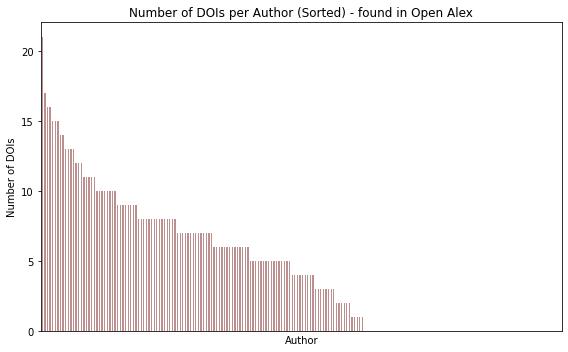

In [42]:
author_doi_counts = dois_df.groupby('Author')['DOIs count'].sum()

author_doi_counts = author_doi_counts.sort_values(ascending=False)

plt.figure(figsize=(8, 5))
author_doi_counts.plot(kind='bar', color='rosybrown')
plt.title('Number of DOIs per Author (Sorted) - found in Open Alex')
plt.ylabel('Number of DOIs')
plt.locator_params(axis='y', integer=True)
plt.xticks([])
plt.tight_layout()
plt.show()

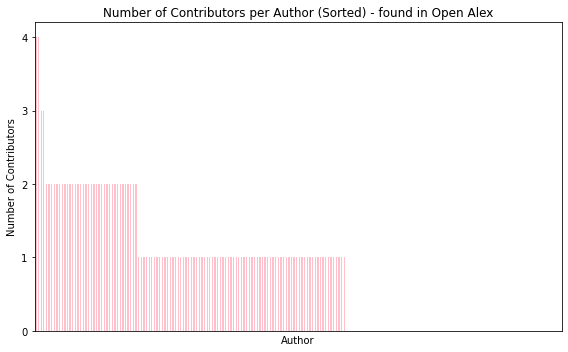

In [43]:
author_contributors_count = dois_df.groupby('Author')['Number of contributors with DOIs found in OpenAlex'].sum()

author_contributors_count = author_contributors_count.sort_values(ascending=False)

plt.figure(figsize=(8, 5))
author_contributors_count.plot(kind='bar', color='pink')
plt.title('Number of Contributors per Author (Sorted) - found in Open Alex')
plt.ylabel('Number of Contributors')
plt.locator_params(axis='y', integer=True)
plt.xticks([])
plt.tight_layout()
plt.show()

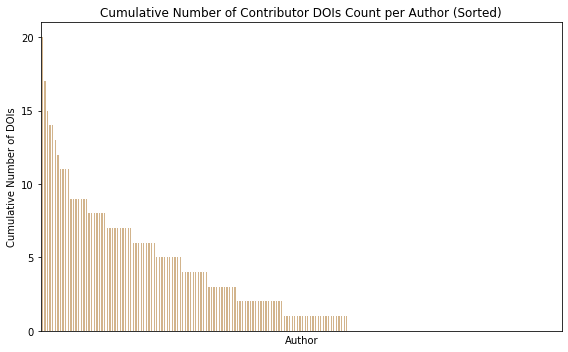

In [28]:
author_cumulative_dois_count = dois_df.groupby('Author')['Cumulative found Contributor DOIs count'].sum()

author_cumulative_dois_count = author_cumulative_dois_count.sort_values(ascending=False)

plt.figure(figsize=(8, 5))
author_cumulative_dois_count.plot(kind='bar', color='tan')
plt.title('Cumulative Number of Contributor DOIs Count per Author (Sorted)')
plt.ylabel('Cumulative Number of DOIs')

plt.locator_params(axis='y', integer=True)

plt.xticks([])
plt.tight_layout()
plt.show()

In [29]:
mean_dois_per_author = dois_df['DOIs count'].mean()
median_dois_per_author = dois_df['DOIs count'].median()

mean_found_contributors = dois_df['Number of contributors with DOIs found in OpenAlex'].mean()
median_found_contributors = dois_df['Number of contributors with DOIs found in OpenAlex'].median()

mean_cumulative_dois_count = dois_df['Cumulative found Contributor DOIs count'].mean()
median_cumulative_dois_count = dois_df['Cumulative found Contributor DOIs count'].median()

nan_author_dois_count = dois_df['Author DOIs found in OpenAlex'].isnull().sum()
nan_contributors_dois_count = dois_df['Contributors-DOIs Dictionary'].isnull().sum()

summary_data = {
    'Statistics': ['Mean DOIs per Author', 'Median DOIs per Author',
                   'Mean Found Contributors', 'Median Found Contributors',
                   'Mean Cumulative DOIs Count', 'Median Cumulative DOIs Count',
                   'NaN Values for Author DOIs', 'NaN Values for Contributors DOIs'],
    'Values': [mean_dois_per_author, median_dois_per_author,                           # round if needed
               mean_found_contributors, median_found_contributors,
               mean_cumulative_dois_count, median_cumulative_dois_count,
               nan_author_dois_count, nan_contributors_dois_count]
}

summary_df = pd.DataFrame(summary_data)

summary_df

,Statistics,Values
0,Mean DOIs per Author,4.485
1,Median DOIs per Author,4.000
2,Mean Found Contributors,0.815
3,Median Found Contributors,1.000
4,Mean Cumulative DOIs Count,2.880
5,Median Cumulative DOIs Count,1.000
6,NaN Values for Author DOIs,76.000
7,NaN Values for Contributors DOIs,82.000


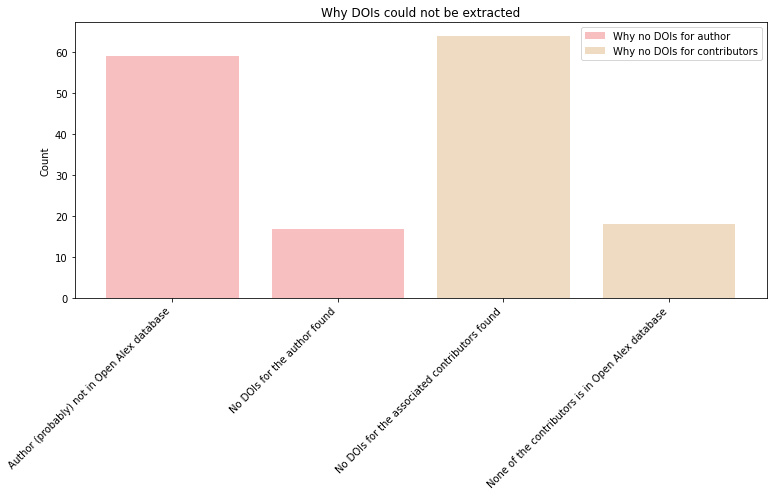

In [52]:
dois_df.fillna('Unknown', inplace=True)

unique_messages_column1 = dois_df['Why no DOIs for author'].value_counts()
unique_messages_column2 = dois_df['Why no DOIs for contributors'].value_counts()

unique_messages_column1 = unique_messages_column1.drop('Unknown', errors='ignore')
unique_messages_column2 = unique_messages_column2.drop('Unknown', errors='ignore')

plt.figure(figsize=(11, 7))

plt.bar(unique_messages_column1.index, unique_messages_column1.values, alpha=0.5, label='Why no DOIs for author', color='lightcoral')
plt.bar(unique_messages_column2.index, unique_messages_column2.values, alpha=0.5, label='Why no DOIs for contributors', color='burlywood')

plt.ylabel('Count')
plt.title('Why DOIs could not be extracted')
plt.xticks(rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()

### Filter for the task at hand

In [30]:
df_clean = dois_df.iloc[:, :6].dropna()
# df_clean.reset_index(drop=True, inplace=True)
df_clean

,Author,Author DOIs found in OpenAlex,DOIs count,Contributors-DOIs Dictionary,Number of contributors with DOIs found in OpenAlex,Cumulative found Contributor DOIs count
1,Patricia van Velzen,[https://doi.org/10.1016/s2213-2600(17)30165-0...,5,{'J. M. Prins': ['https://doi.org/10.1007/978-...,1,2
2,Teele Kuusk,"[https://doi.org/10.1186/s12894-015-0118-2, ht...",4,"{'S. Horenblas': [], 'A. Bex': ['https://doi.o...",1,1
4,Michiel A. J. Luijten,"[https://doi.org/10.1007/s11136-021-02861-x, h...",7,{'M. A. Grootenhuis': ['https://doi.org/10.108...,1,4
5,Evelyne Jeannette Demkes,"[https://doi.org/10.3389/fphar.2021.702326, ht...",2,"{'J. Sluijter': [], 'I. Höfer': ['https://doi....",1,1
8,Jiayi Pei,"[https://doi.org/10.1186/s13148-021-01043-3, h...",6,{'F. Asselbergs': ['https://doi.org/10.1097/00...,2,2
...,...,...,...,...,...,...
185,Robin D. Blok,"[https://doi.org/10.1016/j.ejso.2018.03.033, h...",10,{'J. P. Medema': ['https://doi.org/10.1128/mcb...,1,2
186,Anissa M. Tsonas,"[https://doi.org/10.1016/j.jcrc.2022.154022, h...",4,"{'M. J. Schultz': [], 'J. Horn': ['https://doi...",1,7
187,C. Salgado,"[https://doi.org/10.1371/journal.pone.0231418,...",8,"{'M. Vermeer': [], 'J. Morreau': ['https://doi...",2,4
188,Lotte Boxhoorn,[https://doi.org/10.1016/s0140-6736(20)31310-6...,14,"{'P. Fockens': [], 'R. P. Voermans': ['https:/...",2,2


In [31]:
mean_dois_per_author = df_clean['DOIs count'].mean()
median_dois_per_author = df_clean['DOIs count'].median()

mean_found_contributors = df_clean['Number of contributors with DOIs found in OpenAlex'].mean()
median_found_contributors = df_clean['Number of contributors with DOIs found in OpenAlex'].median()

mean_cumulative_dois_count = df_clean['Cumulative found Contributor DOIs count'].mean()
median_cumulative_dois_count = df_clean['Cumulative found Contributor DOIs count'].median()

summary_data = {
    'Statistics': ['Mean DOIs per Author', 'Median DOIs per Author',
                   'Mean Found Contributors', 'Median Found Contributors',
                   'Mean Cumulative DOIs Count', 'Median Cumulative DOIs Count'],
    'Values': [mean_dois_per_author, median_dois_per_author,
               mean_found_contributors, median_found_contributors,
               mean_cumulative_dois_count, median_cumulative_dois_count]
}

summary_df = pd.DataFrame(summary_data)

summary_df

,Statistics,Values
0,Mean DOIs per Author,7.405405
1,Median DOIs per Author,7.000000
2,Mean Found Contributors,1.418919
3,Median Found Contributors,1.000000
4,Mean Cumulative DOIs Count,4.756757
5,Median Cumulative DOIs Count,4.000000


In [35]:
# df_clean.to_csv('full_info_200_rs42.csv', index=False) # x - nr of rows

# Logistic Regression

### Get additional features from the data

In [36]:
def get_features(row):
    row = sampled_df.iloc[row]
    return row['institution'], 2024-int(row['year'][:4]), row.iloc[7:17].count()

In [37]:
get_features(6)

('vumc', 4, 3)

In [38]:
def target_DOI(row):
    author_id = confirm_author(row)
    if author_id not in ["Confirming author not successful", "Title not matched"]:
        DOIs = []
        query = Works().search_filter(title=title_transform(row)).get()
        for response in query:
            for authorship in response["authorships"]:
                if authorship["author"]["id"] == author_id:
                    DOIs.append((response["doi"], response['open_access']['is_oa']))
        if len(DOIs)>1:
            return "More than one DOI found - multiple publications"  # does it work like this?
        return DOIs[0][1]
    else:
        return np.nan                                                 # (probably) no DOI for the title in Open Alex

### Dataframe for the model

##### Dataframe description:

1 Index of the title in the sampled dataset 

2 Ratio of open access in author's other works 

3 Number of author works in Open Alex 

4 Number of contributors supervising this title

5 Ratio of open access for (all) contributors

6 Institution

7 How old is the title

8 (target variable) Open Access of the title

In [39]:
values = []
for index, row in df_clean.iterrows():                   # ADD TO DOIS DF CREATION!

    open_access_author = 0
    for doi in row['Author DOIs found in OpenAlex']:
        if Works()[doi]['open_access']['is_oa'] == True:
            open_access_author += 1
            
    open_access_contributors = 0 
    for value in row['Contributors-DOIs Dictionary'].values():
        if value != []:
            for doi in value:
                if Works()[doi]['open_access']['is_oa'] == True:
                    open_access_contributors += 1

    data = {'Index': index, 'Institution': get_features(index)[0], 'Age': get_features(index)[1], 'Author DOIs count': row['DOIs count'], 'Author open access ratio': open_access_author/row['DOIs count'], "Open Access": target_DOI(index), "Contributors count": get_features(index)[2], 'Contributors open access ratio': open_access_contributors/row['Cumulative found Contributor DOIs count']}
    values.append(data)

25 match(es) for the title found
Could not match Patricia van Velzen to ['Michael Bryan Rothberg', 'M B Rothberg', 'Michael B. Rothberg', 'Michael Rothberg', 'M. Rothberg']
Could not match Patricia van Velzen to ['Penelope. Pekow', 'Penelope Susan Pekow', 'P. S. Pekow', 'P. Pekow', 'Penelope S. Pekow']
Could not match Patricia van Velzen to ['Maureen C. Lahti', 'Maureen Lahti']
Could not match Patricia van Velzen to ['Oren Brody']
Could not match Patricia van Velzen to ['D. Skiest', 'Daniel Skiest', 'D.J Skiest', 'Daniel J. Skiest', 'D. J. Skiest']
Could not match Patricia van Velzen to ['Peter Lindenauer', 'Peter K. Lindenauer', 'Lindenauer Peter', 'P.K Lindenauer', 'P Lindenauer', 'P. K. Lindenauer']
Could not match Patricia van Velzen to ['Robert Charles . Auteur du texte Wilson', 'Robert Charles Wilson', 'R. C. Wilson', 'R.C Wilson', 'Wilson Robert', 'R. Wilson', 'Robert C. Wilson', 'Richard C.L. Wilson', 'Robert Wilson']
Could not match Patricia van Velzen to ['Sanjay Sethi', 'San

Could not match Patricia van Velzen to ['Sarah D. Haessler', 'Sarah Haessler', 'S. Haessler']
Could not match Patricia van Velzen to ['Penelope. Pekow', 'Penelope Susan Pekow', 'P. S. Pekow', 'P. Pekow', 'Penelope S. Pekow']
Could not match Patricia van Velzen to ['Michael Bryan Rothberg', 'M B Rothberg', 'Michael B. Rothberg', 'Michael Rothberg', 'M. Rothberg']
Could not match Patricia van Velzen to ['Jerry A. Krishnan', 'J. Krishnan', 'Jerry Krishnan', 'J. A. Krishnan']
Could not match Patricia van Velzen to ['A. J. Walkey', 'Allan Walkey', 'A. Walkey', 'Allan Jay Walkey', 'Allan J. Walkey']
Could not match Patricia van Velzen to ['Salwan Al‐ani', 'Salwan Tariq Al‐ani', 'Salwan Tariq AlAni']
Could not match Patricia van Velzen to ['M.H. Spigt', 'M Spigt', 'Marcus Spigt']
Could not match Patricia van Velzen to ['J Laue', 'Johanna Laue']
Could not match Patricia van Velzen to ['Hassee Melbye', 'H. Melbye', 'Hasse Melbye', 'Melbye']
Could not match Patricia van Velzen to ['Nita K. Gupta

Could not match Matty L. Terpstra to ['James Wayne Williams', 'James W.A. Williams', 'J. W. Williams', 'James Williams', 'J. Williams', 'J.W Williams', 'James W. Williams']
Could not match Matty L. Terpstra to ['M. A. Josephson', 'Medicine Josephson', 'Michelle A. Josephson', 'M. Josephson', 'Michelle Josephson', 'M.A Josephson']
Could not match Matty L. Terpstra to ['B. Javaid', 'Basit Javaid', 'Javaid Basit']
Could not match Matty L. Terpstra to ['S. Gupta', 'Samir Kumar Gupta', 'Samir Gupta', 'Samir K. Gupta', 'S. K. Gupta']
Could not match Matty L. Terpstra to ['D. Kitch', 'Douglas Kitch', 'D. W. Kitch', 'Douglas W. Kitch']
Could not match Matty L. Terpstra to ['Camlin Tierney', 'C. Tierney']
Could not match Matty L. Terpstra to ['Kathleen Melbourne', 'Kathleen M. Melbourne']
Could not match Matty L. Terpstra to ['B. Ha', 'Belinda Ha', 'Ha B', 'Belinda F. Ha', 'Ha Belinda']
Could not match Matty L. Terpstra to ['Grace Mccomsey', 'GA. McComsey', 'Grace A. Mccomsey', 'G. McComsey', '

In [40]:
reg_df = pd.DataFrame(values)
reg_df = reg_df.dropna() # discard nan for open access
reg_df

,Index,Institution,Age,Author DOIs count,Author open access ratio,Open Access,Contributors count,Contributors open access ratio
0,1,amcpub,4,5,0.400000,False,2,0.000000
1,2,umcu,4,4,0.250000,True,2,0.000000
3,5,umcu,3,2,1.000000,False,2,1.000000
4,8,umcu,4,6,0.833333,True,2,0.000000
5,9,umcu,4,7,1.000000,True,2,1.000000
6,10,vumc,4,3,1.000000,False,3,0.125000
7,13,umcu,3,5,0.800000,True,1,0.000000
9,20,lumc,3,9,0.555556,False,5,0.333333
10,23,lumc,3,6,0.500000,False,5,0.066667
15,36,vumc,4,7,1.000000,False,3,1.000000


## Model

In [64]:
x = reg_df.drop(['Index', 'Open Access'], axis=1)
y = reg_df[['Open Access']]